# library importing

In [2]:
import os
import json
import csv
# import dis
import json
import math
import re
import platform
import statistics
import subprocess
# import requests
import zipfile
import os
import shutil
import random
import glob
import copy
import inspect
import importlib.util

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from typing import Dict, Tuple, Callable, Any, Optional, List
from types import MappingProxyType, FunctionType
from tqdm.auto import tqdm

from composite_score_calculator import CompositeScoreCalculator
from instruction_cost_model import InstructionCostModel
from enhanced_cost_analyzer import EnhancedCostAnalyzer
from reporting import create_repository_comparison_chart, DEFAULT_REPORT_DIR
from utils import utils as u

# constants

In [ ]:
def load_configuration(config_file: str = DEFAULT_CONFIG_WEIGHTS_PATH) -> tuple:
    """
    Loads configuration from JSON file and creates constant dictionaries.

    Args:
        config_file: Path to configuration file

    Returns:
        tuple: Tuple with all constant dictionaries
    """
    try:
        with open(config_file, 'r', encoding='utf-8') as f:
            config_data = json.load(f)

        # Extract weight profiles (using 'weights' subkey if structured format)
        weight_profiles = config_data['weight_profiles']

        # Handle both simple and structured formats
        def extract_weights(profile_data):
            if isinstance(profile_data, dict) and 'weights' in profile_data:
                return profile_data['weights']
            return profile_data

        # Create constants for weight profiles
        DEFAULT_COMPOSITE_WEIGHTS = extract_weights(weight_profiles['default_composite'])
        RESEARCH_WEIGHTS = extract_weights(weight_profiles['research'])
        COMMERCIAL_WEIGHTS = extract_weights(weight_profiles['commercial'])
        MOBILE_WEIGHTS = extract_weights(weight_profiles['mobile'])
        HPC_WEIGHTS = extract_weights(weight_profiles['hpc'])

        # Handle reference values
        reference_data = config_data['reference_values']
        if 'values' in reference_data:
            REFERENCE_VALUES = reference_data['values']
        else:
            REFERENCE_VALUES = reference_data

        return (
            DEFAULT_COMPOSITE_WEIGHTS,
            RESEARCH_WEIGHTS,
            COMMERCIAL_WEIGHTS,
            MOBILE_WEIGHTS,
            HPC_WEIGHTS,
            REFERENCE_VALUES
        )

    except FileNotFoundError:
        raise FileNotFoundError(f"Configuration file '{config_file}' not found")
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON format in configuration file: {e}")
    except KeyError as e:
        raise KeyError(f"Missing required configuration key: {e}")


# Alternative approach with class for encapsulation
class WeightConfiguration:
    """Class for managing weight coefficient configuration."""

    def __init__(self, config_file: str = DEFAULT_CONFIG_WEIGHTS_PATH):
        self._load_config(config_file)

    def _load_config(self, config_file: str) -> None:
        """Loads configuration from file."""
        with open(config_file, 'r', encoding='utf-8') as f:
            config_data = json.load(f)

        # Create class attributes
        profiles = config_data['weight_profiles']
        self.DEFAULT_COMPOSITE_WEIGHTS = profiles['default_composite']
        self.RESEARCH_WEIGHTS = profiles['research']
        self.COMMERCIAL_WEIGHTS = profiles['commercial']
        self.MOBILE_WEIGHTS = profiles['mobile']
        self.HPC_WEIGHTS = profiles['hpc']
        self.REFERENCE_VALUES = config_data['reference_values']

    def get_profile(self, profile_name: str) -> Dict[str, float]:
        """Returns weight profile by name."""
        profile_mapping = {
            'default_composite': self.DEFAULT_COMPOSITE_WEIGHTS,
            'research': self.RESEARCH_WEIGHTS,
            'commercial': self.COMMERCIAL_WEIGHTS,
            'mobile': self.MOBILE_WEIGHTS,
            'hpc': self.HPC_WEIGHTS
        }

        if profile_name not in profile_mapping:
            raise ValueError(f"Unknown profile: {profile_name}")

        return profile_mapping[profile_name]

    def validate_weights(self, weights: Dict[str, float]) -> bool:
        """Validates that weight sum equals 1.0 and all keys are present."""
        required_keys = {'CU', 'EU', 'CO2', '$'}

        if set(weights.keys()) != required_keys:
            return False

        total_weight = sum(weights.values())
        return abs(total_weight - 1.0) < 1e-10

In [ ]:
# CARBON_INTENSITY_API = "https://api.carbonintensity.org.uk/intensity"
# DEFAULT_CARBON_INTENSITY = 0.2  # Fallback value in kgCO2/kWh
DEFAULT_COST_MODEL_PATH = "./cost_models"
DEFAULT_EXAMPLES_PATH = "./examples"
SAVING_FLAG = True
# CHECKING_WEIGHTS_FLAG = False
# DEFAULT_REPORT_DIR = "./enhanced_reports"
# DEFAULT_CONFIG_WEIGHTS_PATH = DEFAULT_COST_MODEL_PATH + '/config_weights.json'

# (DEFAULT_COMPOSITE_WEIGHTS, RESEARCH_WEIGHTS, COMMERCIAL_WEIGHTS,
#   MOBILE_WEIGHTS, HPC_WEIGHTS, REFERENCE_VALUES) = load_configuration()

# PROFILE_WEIGHTS = MappingProxyType({
#     "RESEARCH": RESEARCH_WEIGHTS,
#     "COMMERCIAL": COMMERCIAL_WEIGHTS,
#     "MOBILE": MOBILE_WEIGHTS,
#     "HPC": HPC_WEIGHTS,
#     "DEFAULT": DEFAULT_COMPOSITE_WEIGHTS,
# })

# if CHECKING_WEIGHTS_FLAG:
#   # usage by class
#   config = WeightConfiguration()
#   research_profile = config.get_profile('research')
#   print(f"Research profile: {research_profile}")

#   # validation
#   is_valid = config.validate_weights(config.RESEARCH_WEIGHTS)
#   print(f"Research weights valid: {is_valid}")


def process_zip_file(zip_filename, target_directory):
    """
    Unzips a zip file to the specified directory and deletes the archive
    """
    zip_path = f'./{zip_filename}'

    if not os.path.exists(zip_path):
        print(f"Error: file {zip_path} not found!")
        return False

    os.makedirs(target_directory, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Extracting {zip_filename}...")

            file_list = zip_ref.namelist()
            print(f"Files found in archive: {len(file_list)}")

            zip_ref.extractall(target_directory)

            for file_name in file_list:
                extracted_path = os.path.join(target_directory, file_name)
                if os.path.isfile(extracted_path):
                    file_size = os.path.getsize(extracted_path)
                    print(f"Exctracted: {file_name} ({file_size} byte)")

        os.remove(zip_path)
        print(f"Zip-file {zip_filename} has been deleted")

        print(f"Operation completed successfully! Files saved in: {target_directory}")
        return True

    except zipfile.BadZipFile:
        print(f"Erroe: {zip_filename} is corrupted or is not a zip file")
        return False
    except Exception as e:
        print(f"Error while processing: {str(e)}")
        return False


os.makedirs(DEFAULT_COST_MODEL_PATH[2:], exist_ok=True)
os.makedirs(DEFAULT_EXAMPLES_PATH[2:], exist_ok=True)
zip_filename_models = "cost_models.zip"
zip_filename_examples = "examples.zip"

# from utils import utils as u
# # from instruction_cost_model import InstructionCostModel

process_zip_file(zip_filename_models, DEFAULT_COST_MODEL_PATH)
process_zip_file(zip_filename_examples, DEFAULT_EXAMPLES_PATH)

In [ ]:
!wget https://example.com/file.zip

# needed functions and classes

In [ ]:
class CompositeScoreCalculator:
    """
    Calculator for unified composite scores based on multiple cost metrics.

    Provides normalization, scaling, and weighted combination of cost metrics
    into a single composite score for algorithm comparison.
    """

    def __init__(self,
                 weights: Optional[Dict[str, float]] = None,
                 profile: str = "DEFAULT",
                 reference_values: Optional[Dict[str, Dict[str, float]]] = None):
        """
        Initialize composite score calculator.

        Args:
            weights: Weight distribution for metrics (must sum to 1.0)
            profile: Predefined profile name ('HPC', 'MOBILE', 'COMMERCIAL', 'RESEARCH', 'DEFAULT')
            reference_values: Reference values for normalization
        """
        self.profile = profile

        if weights is not None:
            self.weights = dict(weights)
        elif profile is not None:
            if profile not in PROFILE_WEIGHTS:
                raise ValueError(f"Unknown profile: {profile}. Available: {list(PROFILE_WEIGHTS.keys())}")
            self.weights = PROFILE_WEIGHTS[profile].copy()
        else:
            self.weights = DEFAULT_COMPOSITE_WEIGHTS.copy()

        self.reference_values = copy.deepcopy(reference_values) if reference_values else copy.deepcopy(REFERENCE_VALUES)

        # Validate weights sum to 1.0
        weight_sum = sum(self.weights.values())
        if abs(weight_sum - 1.0) > 1e-6:
            raise ValueError(f"Weights must sum to 1.0, got {weight_sum}")

    def normalize_metric(self, value: float, metric: str, method: str = "minmax") -> float:
        """
        Normalize a metric value to 0-100 scale.

        Args:
            value: Raw metric value
            metric: Metric name (CU, EU, CO2, $)
            method: Normalization method ('minmax', 'zscore', 'log')

        Returns:
            Normalized score (0-100)
        """
        if metric not in self.reference_values:
            return 50.0  # Default middle value for unknown metrics

        ref = self.reference_values[metric]
        min_val, max_val = ref["min"], ref["max"]

        if method == "minmax":
            # Min-max normalization with inversion (lower is better)
            if max_val <= min_val:
                return 50.0
            normalized = (value - min_val) / (max_val - min_val)
            # Invert: lower cost = higher score
            return max(0.0, min(100.0, 100.0 * (1.0 - normalized)))

        elif method == "zscore":
            # Z-score normalization using typical value as mean
            typical = ref["typical"]
            std_estimate = (max_val - min_val) / 6  # Rough 6-sigma estimate
            if std_estimate <= 0:
                return 50.0
            z_score = (value - typical) / std_estimate
            # Convert to percentile and invert
            percentile = self._z_to_percentile(-z_score)  # Negative for inversion
            return max(0.0, min(100.0, percentile))

        elif method == "log":
            # Logarithmic normalization for highly skewed data
            if value <= 0 or min_val <= 0 or max_val <= min_val:
                return 50.0
            log_val = math.log(value)
            log_min = math.log(min_val)
            log_max = math.log(max_val)
            normalized = (log_val - log_min) / (log_max - log_min)
            return max(0.0, min(100.0, 100.0 * (1.0 - normalized)))

        else:
            raise ValueError(f"Unknown normalization method: {method}")

    def _z_to_percentile(self, z_score: float) -> float:
        """Convert z-score to percentile using approximation."""
        # Approximation of cumulative normal distribution
        return 50.0 * (1.0 + math.erf(z_score / math.sqrt(2)))

    def calculate_composite_score(self, metrics: Dict[str, float],
                                method: str = "minmax") -> Dict[str, float]:
        """
        Calculate composite score from individual metrics.

        Args:
            metrics: Dictionary with raw metric values
            method: Normalization method to use

        Returns:
            Dictionary with normalized scores and composite score
        """
        normalized_scores = {}

        # Normalize each metric
        for metric, value in metrics.items():
            if metric in self.weights:
                normalized_scores[f"{metric}_normalized"] = self.normalize_metric(
                    value, metric, method
                )

        # Calculate weighted composite score
        composite_score = 0.0
        for metric, weight in self.weights.items():
            normalized_key = f"{metric}_normalized"
            if normalized_key in normalized_scores:
                composite_score += weight * normalized_scores[normalized_key]

        # Add composite score to results
        result = metrics.copy()
        result.update(normalized_scores)
        result["COMPOSITE_SCORE"] = composite_score

        # Add score interpretation
        result["SCORE_GRADE"] = self._get_score_grade(composite_score)
        result["EFFICIENCY_RATING"] = self._get_efficiency_rating(composite_score)

        return result

    def _get_score_grade(self, score: float) -> str:
        """Convert numeric score to letter grade."""
        if score >= 90: return "A+"
        elif score >= 85: return "A"
        elif score >= 80: return "A-"
        elif score >= 75: return "B+"
        elif score >= 70: return "B"
        elif score >= 65: return "B-"
        elif score >= 60: return "C+"
        elif score >= 55: return "C"
        elif score >= 50: return "C-"
        elif score >= 40: return "D"
        else: return "F"

    def _get_efficiency_rating(self, score: float) -> str:
        """Convert numeric score to efficiency rating."""
        if score >= 85: return "Excellent"
        elif score >= 70: return "Good"
        elif score >= 55: return "Average"
        elif score >= 40: return "Below Average"
        else: return "Poor"

    def update_reference_values(self, benchmark_results: List[Dict[str, float]]) -> None:
        """
        Update reference values based on benchmark results.

        Args:
            benchmark_results: List of metric dictionaries from benchmark runs
        """
        if not benchmark_results:
            return

        for metric in self.weights.keys():
            values = [result.get(metric, 0) for result in benchmark_results if metric in result]
            if values:
                self.reference_values[metric] = {
                    "min": min(values),
                    "max": max(values),
                    "typical": statistics.median(values)
                }

    def get_profile_info(self) -> Dict[str, Any]:
        """
        Get information about current weight profile.

        Returns:
            Dictionary with profile information
        """
        return {
            "profile": self.profile,
            "weights": self.weights.copy(),
            "description": self._get_profile_description()
        }

    def _get_profile_description(self) -> str:
        """Get description of current profile."""
        descriptions = {
            "HPC": "High Performance Computing - optimized for maximum computational throughput",
            "MOBILE": "Mobile/IoT - optimized for energy efficiency and battery life",
            "COMMERCIAL": "Commercial Cloud - balanced approach with cost consideration",
            "RESEARCH": "Research/Academic - focused on performance with environmental awareness",
            "DEFAULT": "Default balanced profile for general use cases",
            "CUSTOM": "Custom weight configuration"
        }
        return descriptions.get(self.profile, "Custom profile configuration")


class InstructionCostModel:
    """
    Model for instruction costs across different architectures.

    Loads cost models from JSON files and provides cost lookup functionality
    for different instruction types across various metrics (CU, EU, CO2, $).
    """

    def __init__(self, arch: str) -> None:
        """
        Initialize instruction cost model for specified architecture.

        Args:
            arch: Target architecture (e.g., 'x86_64', 'arm', 'gpu')

        Raises:
            RuntimeError: If cost model file for architecture is not found
        """
        self.arch = arch.lower()
        self.weights = self._load_weights()
        self.bytecode_mapping = self._get_bytecode_mapping()

    def _load_weights(self) -> Dict[str, Dict[str, float]]:
        """
        Load instruction weights from architecture-specific JSON file.

        Returns:
            Dictionary mapping instruction names to cost metrics

        Raises:
            RuntimeError: If cost model file cannot be loaded
        """
        # Try multiple ways to find the correct path
        possible_paths = []

        # Method 1: Use __file__ if available
        try:
            script_dir = os.path.dirname(os.path.abspath(__file__))
            possible_paths.append(os.path.join(script_dir, f"cost_models/{self.arch}_instr_costs.json"))
        except NameError:
            pass

        # Method 2: Current working directory
        possible_paths.append(f"cost_models/{self.arch}_instr_costs.json")

        # Method 3: Relative to current directory
        possible_paths.append(f"./{self.arch}_instr_costs.json")

        # Method 4: Check if DEFAULT_COST_MODEL_PATH exists
        if os.path.exists(DEFAULT_COST_MODEL_PATH):
            possible_paths.append(
                os.path.join(DEFAULT_COST_MODEL_PATH, f"{self.arch}_instr_costs.json")
            )

        # Try each path until one works
        for model_file in possible_paths:
            try:
                if os.path.exists(model_file):
                    with open(model_file, 'r', encoding='utf-8') as f:
                        return json.load(f)
            except (FileNotFoundError, json.JSONDecodeError, PermissionError):
                continue

        # If no file found, use default fallback model
        print(f"Warning: Cost model not found for architecture: {self.arch}. Using default values.")
        return self._get_default_cost_model()

    def _get_default_cost_model(self) -> Dict[str, Dict[str, float]]:
        """Get default cost model when no file is available."""
        return {
            "ADD": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "SUB": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "MUL": {"CU": 3.0, "EU": 0.0003, "CO2": 0.00015, "$": 0.00003},
            "DIV": {"CU": 10.0, "EU": 0.001, "CO2": 0.0005, "$": 0.0001},
            "LOAD": {"CU": 2.0, "EU": 0.0002, "CO2": 0.0001, "$": 0.00002},
            "STORE": {"CU": 2.0, "EU": 0.0002, "CO2": 0.0001, "$": 0.00002},
            "JMP": {"CU": 1.5, "EU": 0.00015, "CO2": 0.000075, "$": 0.000015},
            "CALL": {"CU": 5.0, "EU": 0.0005, "CO2": 0.00025, "$": 0.00005},
            "MOV": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "AND": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "OR": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "XOR": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001}
        }

    def _get_bytecode_mapping(self) -> Dict[str, str]:
        """
        Get mapping from Python bytecode instructions to architecture instructions.

        Returns:
            Dictionary mapping bytecode ops to architecture ops
        """
        return {
            'BINARY_ADD': 'ADD',
            'BINARY_SUBTRACT': 'SUB',
            'BINARY_MULTIPLY': 'MUL',
            'BINARY_TRUE_DIVIDE': 'DIV',
            'BINARY_FLOOR_DIVIDE': 'DIV',
            'BINARY_AND': 'AND',
            'BINARY_OR': 'OR',
            'BINARY_XOR': 'XOR',
            'LOAD_CONST': 'LOAD',
            'LOAD_FAST': 'LOAD',
            'LOAD_GLOBAL': 'LOAD',
            'STORE_FAST': 'STORE',
            'STORE_GLOBAL': 'STORE',
            'STORE_NAME': 'STORE',
            'JUMP_FORWARD': 'JMP',
            'JUMP_IF_TRUE_OR_POP': 'JMP',
            'JUMP_IF_FALSE_OR_POP': 'JMP',
            'CALL_FUNCTION': 'CALL',
            'RETURN_VALUE': 'MOV'
        }

    def get_cost(self, opname: str, is_bytecode: bool = False) -> Tuple[float, float, float, float]:
        """
        Get cost metrics for specified instruction.

        Args:
            opname: Instruction operation name
            is_bytecode: Whether the opname is Python bytecode instruction

        Returns:
            Tuple of (CU, EU, CO2, $) cost values
        """
        opname = opname.upper()

        # Map Python bytecode to architecture instruction if needed
        if is_bytecode and opname in self.bytecode_mapping:
            opname = self.bytecode_mapping[opname]

        data = self.weights.get(opname)

        if data is None:
            # Default fallback values for unknown instructions
            default_values = {
                "CU": 1.0,
                "EU": 0.0001,
                "CO2": 0.00005,
                "$": 0.00001
            }
            return (
                default_values["CU"],
                default_values["EU"],
                default_values["CO2"],
                default_values["$"]
            )

        # Extract only the required metrics, ignoring extra fields
        return (
            data.get("CU", 1.0),
            data.get("EU", 0.0001),
            data.get("CO2", 0.00005),
            data.get("$", 0.00001)
        )


class EnhancedCostAnalyzer:
    """
    Enhanced analyzer class for evaluating algorithm costs with composite scoring.

    Provides methods to analyze Python functions, LLVM IR, and PTX code
    to estimate computational costs across multiple metrics, including
    unified composite scores for algorithm comparison.
    """

    def __init__(self, arch: str = "x86_64",
                 composite_weights: Optional[Dict[str, float]] = None,
                 profile: str = "DEFAULT") -> None:
        """
        Initialize enhanced cost analyzer with specified architecture.

        Args:
            arch: Target architecture for cost model
            composite_weights: Custom weights for composite score calculation
            profile: Predefined profile name ('HPC', 'MOBILE', 'COMMERCIAL', 'RESEARCH', 'DEFAULT')
        """
        self.arch = arch
        self.profile = profile
        self.weights = copy.deepcopy(composite_weights) if composite_weights \
                       else copy.deepcopy(PROFILE_WEIGHTS.get(profile, DEFAULT_COMPOSITE_WEIGHTS))
        self.model = InstructionCostModel(arch=arch)
        self.composite_calculator = CompositeScoreCalculator(
            weights=self.weights,
            profile=profile
        )
        self.benchmark_history = []

    def analyze_function(self, fn: Callable[..., Any],
                        include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze Python function bytecode and calculate costs with composite score.

        Args:
            fn: Python function to analyze
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score
        """
        instructions = list(dis.get_instructions(fn))
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        for instr in instructions:
            cu, eu, co2, money = self.model.get_cost(instr.opname, is_bytecode=True)
            summary["CU"] += cu
            summary["EU"] += eu
            summary["CO2"] += co2
            summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def analyze_llvm_ir(self, ir_path: str, include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze LLVM IR file and calculate costs with composite score.

        Args:
            ir_path: Path to LLVM IR file (.ll)
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score

        Raises:
            FileNotFoundError: If IR file cannot be found
        """
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        with open(ir_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith(';'):
                    continue

                tokens = line.split()
                if tokens:
                    # Find actual instruction (skip assignments like %1 =)
                    opcode = None
                    for token in tokens:
                        if '=' not in token and not token.startswith('%'):
                            opcode = token.upper()
                            break

                    if opcode:
                        cu, eu, co2, money = self.model.get_cost(opcode)
                        summary["CU"] += cu
                        summary["EU"] += eu
                        summary["CO2"] += co2
                        summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def analyze_ptx(self, ptx_path: str, include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze PTX (Parallel Thread Execution) file and calculate costs with composite score.

        Args:
            ptx_path: Path to PTX file (.ptx)
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score

        Raises:
            FileNotFoundError: If PTX file cannot be found
        """
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        with open(ptx_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if (not line or line.startswith(';') or line.startswith('//') or
                    line.startswith('.') or line.startswith('{')):
                    continue

                tokens = line.split()
                if tokens:
                    instr = tokens[0].upper().rstrip(':')
                    # Skip labels and directives
                    if not instr.endswith(':') and not instr.startswith('.'):
                        cu, eu, co2, money = self.model.get_cost(instr)
                        summary["CU"] += cu
                        summary["EU"] += eu
                        summary["CO2"] += co2
                        summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def fetch_carbon_intensity(self) -> float:
        """
        Fetch current carbon intensity from external API.

        Returns:
            Carbon intensity in kgCO2/kWh, or fallback value if API unavailable
        """
        try:
            response = requests.get(CARBON_INTENSITY_API, timeout=5)
            if response.status_code == 200:
                data = response.json()
                # Convert gCO2 to kgCO2
                return data["data"][0]["intensity"]["actual"] / 1000.0
        except (requests.RequestException, KeyError, IndexError):
            pass

        return DEFAULT_CARBON_INTENSITY

    def compare_functions(
        self,
        fn_old: Callable[..., Any],
        fn_new: Callable[..., Any],
        include_composite: bool = True
    ) -> Dict[str, Any]:
        """
        Compare costs between two functions (differential analysis) with composite scores.

        Args:
            fn_old: Original function
            fn_new: New function to compare against
            include_composite: Whether to include composite score analysis

        Returns:
            Dictionary with detailed comparison results
        """
        old_cost = self.analyze_function(fn_old, include_composite)
        new_cost = self.analyze_function(fn_new, include_composite)

        # Calculate raw differences
        differences = {}
        for key in ["CU", "EU", "CO2", "$"]:
            differences[f"{key}_diff"] = new_cost[key] - old_cost[key]
            differences[f"{key}_ratio"] = (new_cost[key] / old_cost[key]) if old_cost[key] > 0 else float('inf')
            differences[f"{key}_percent_change"] = (
                ((new_cost[key] - old_cost[key]) / old_cost[key]) * 100
                if old_cost[key] > 0 else float('inf')
            )

        # Composite score comparison
        if include_composite:
            differences["COMPOSITE_SCORE_diff"] = (
                new_cost["COMPOSITE_SCORE"] - old_cost["COMPOSITE_SCORE"]
            )
            differences["improvement"] = new_cost["COMPOSITE_SCORE"] > old_cost["COMPOSITE_SCORE"]
            differences["old_grade"] = old_cost["SCORE_GRADE"]
            differences["new_grade"] = new_cost["SCORE_GRADE"]

        return {
            "old_metrics": old_cost,
            "new_metrics": new_cost,
            "comparison": differences
        }

    def benchmark_suite(self, functions: List[Tuple[str, Callable[..., Any]]]) -> Dict[str, Any]:
            """
            Run benchmark suite, calibrate reference values, and then recalculate scores.

            Args:
                functions: List of (name, function) tuples to benchmark

            Returns:
                Dictionary with benchmark results and statistics based on calibrated values.
            """
            # --- Step 1: Collect RAW metrics first, without calculating composite scores ---
            raw_results = {}
            for name, func in functions:
                # We call analyze_function with include_composite=False to get only raw CU, EU, etc.
                raw_result = self.analyze_function(func, include_composite=False)
                raw_results[name] = raw_result

            # Extract raw metrics for calibration
            raw_metrics_list = list(raw_results.values())

            # --- Step 2: Calibrate the reference values based on the collected raw data ---
            self.composite_calculator.update_reference_values(raw_metrics_list)
            self.benchmark_history.extend(raw_metrics_list)

            # --- Step 3: Now, recalculate scores for each function using the NEW calibrated references ---
            final_results = {}
            for name, raw_result in raw_results.items():
                # Now we use the calculator to add composite scores to the existing raw results
                final_results[name] = self.composite_calculator.calculate_composite_score(raw_result)

            # --- Step 4: Calculate final statistics based on correctly scored results ---
            stats = self._calculate_benchmark_stats(final_results)

            return {
                "results": final_results, # Return the correctly calculated results
                "statistics": stats,
                "updated_references": self.composite_calculator.reference_values
            }

    def _calculate_benchmark_stats(self, results: Dict[str, Dict[str, float]]) -> Dict[str, Any]:
        """Calculate statistical summary of benchmark results."""
        composite_scores = [result["COMPOSITE_SCORE"] for result in results.values()]

        return {
            "best_algorithm": max(results.keys(), key=lambda k: results[k]["COMPOSITE_SCORE"]),
            "worst_algorithm": min(results.keys(), key=lambda k: results[k]["COMPOSITE_SCORE"]),
            "average_composite_score": statistics.mean(composite_scores),
            "median_composite_score": statistics.median(composite_scores),
            "composite_score_std": statistics.stdev(composite_scores) if len(composite_scores) > 1 else 0,
            "score_range": max(composite_scores) - min(composite_scores)
        }

    def analyze_py_file(self, file_path: str, verbose: bool = True) -> List[Dict[str, Any]]:
        """
        Dynamically imports a Python file and analyzes all top-level functions AND methods
        within top-level classes.

        WARNING: This method executes code from the given file path, which can be a
        security risk if the file is not trusted.

        Args:
            file_path: The full path to the Python (.py) file.
            verbose: If True, prints progress and error messages.

        Returns:
            A list of result dictionaries, one for each function or method found.
        """
        all_executable_results = []

        try:
            module_name = f"dynamic_module_{os.path.basename(file_path).replace('.py', '')}"
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            if spec is None or spec.loader is None:
                if verbose:
                    print(f"Warning: Could not create module spec for {file_path}")
                return []

            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)

            functions_and_methods_to_analyze = []

            for func_name, func_obj in inspect.getmembers(module, inspect.isfunction):
                if func_obj.__module__ == module_name:
                    functions_and_methods_to_analyze.append((func_name, func_obj))

            for class_name, class_obj in inspect.getmembers(module, inspect.isclass):
                if class_obj.__module__ == module_name:
                    for method_name, method_obj in inspect.getmembers(class_obj, inspect.isfunction):
                        descriptive_name = f"{class_name}.{method_name}"
                        functions_and_methods_to_analyze.append((descriptive_name, method_obj))

            if not functions_and_methods_to_analyze:
                return [{
                    'Source File': os.path.basename(file_path),
                    'Function Name': '[No functions or methods found]',
                    'COMPOSITE_SCORE': 0, 'SCORE_GRADE': 'N/A'
                }]

            for name, executable_obj in functions_and_methods_to_analyze:
                if verbose:
                    print(f"    > Found '{name}' in {os.path.basename(file_path)}, analyzing...")
                result = self.analyze_function(executable_obj)
                result['Source File'] = os.path.basename(file_path)
                result['Function Name'] = name
                all_executable_results.append(result)

        except Exception as e:
            if verbose:
                print(f"Error analyzing Python file {file_path}: {e}")
            return [{
                'Source File': os.path.basename(file_path),
                'Function Name': f'[Error: {e}]',
                'COMPOSITE_SCORE': 0, 'SCORE_GRADE': 'Error'
            }]

        return all_executable_results


def save_enhanced_csv(data: Dict[str, Any], filename: str, report_dir: str) -> None:
    """
    Save enhanced cost data to CSV file with composite scores.

    Args:
        data: Dictionary with cost metrics and composite scores
        filename: Output filename
        report_dir: Directory to save reports
    """
    filepath = os.path.join(report_dir, filename)
    with open(filepath, mode="w", newline="", encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Metric", "Value", "Description"])

        # Basic metrics
        basic_metrics = ["CU", "EU", "CO2", "$"]
        for key in basic_metrics:
            if key in data:
                writer.writerow([key, data[key], f"Raw {key} value"])

        # Normalized scores
        for key in basic_metrics:
            normalized_key = f"{key}_normalized"
            if normalized_key in data:
                writer.writerow([normalized_key, data[normalized_key], f"Normalized {key} score (0-100)"])

        # Composite metrics
        if "COMPOSITE_SCORE" in data:
            writer.writerow(["COMPOSITE_SCORE", data["COMPOSITE_SCORE"], "Unified composite score (0-100)"])
        if "SCORE_GRADE" in data:
            writer.writerow(["SCORE_GRADE", data["SCORE_GRADE"], "Letter grade rating"])
        if "EFFICIENCY_RATING" in data:
            writer.writerow(["EFFICIENCY_RATING", data["EFFICIENCY_RATING"], "Efficiency rating"])


def create_enhanced_comparison_chart(
    result1: Dict[str, float],
    result2: Dict[str, float],
    output_filepath: str,  # CHANGED: from report_dir to the full output path
    names: Tuple[str, str] = ("Algorithm v1", "Algorithm v2")
) -> None:
    """
    Create enhanced comparison chart for two algorithms.

    Args:
        result1: Cost metrics for the first algorithm (e.g., the baseline).
        result2: Cost metrics for the second algorithm (e.g., the one to compare).
        output_filepath: The full path where the PNG file will be saved.
        names: Names for the two algorithms for chart legends.
    """
    # Create subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Comparison: "{names[1]}" vs. "{names[0]}"', fontsize=16) # Add a main title

    # --- Raw metrics comparison ---
    raw_metrics = ["CU", "EU", "CO2", "$"]
    values1_raw = [result1.get(m, 0) for m in raw_metrics]
    values2_raw = [result2.get(m, 0) for m in raw_metrics]

    x = np.arange(len(raw_metrics)) # Use numpy for easier calculations
    width = 0.35

    ax1.bar(x - width/2, values1_raw, width, label=names[0], color='skyblue', alpha=0.8)
    ax1.bar(x + width/2, values2_raw, width, label=names[1], color='lightcoral', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(raw_metrics)
    ax1.set_ylabel("Raw Values (Log Scale)")
    ax1.set_title("Raw Metrics Comparison")
    ax1.legend()
    ax1.set_yscale('log')

    # --- Normalized scores comparison ---
    normalized_metrics = [f"{m}_normalized" for m in raw_metrics]
    values1_norm = [result1.get(m, 50) for m in normalized_metrics]
    values2_norm = [result2.get(m, 50) for m in normalized_metrics]

    ax2.bar(x - width/2, values1_norm, width, label=names[0], color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, values2_norm, width, label=names[1], color='lightcoral', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.replace('_normalized', '') for m in normalized_metrics])
    ax2.set_ylabel("Normalized Scores (0-100)")
    ax2.set_title("Normalized Scores Comparison")
    ax2.legend()
    ax2.set_ylim(0, 105) # Increased ylim for text

    # --- Composite score comparison ---
    composite1 = result1.get("COMPOSITE_SCORE", 50)
    composite2 = result2.get("COMPOSITE_SCORE", 50)

    ax3.bar([names[0], names[1]], [composite1, composite2],
            color=['skyblue', 'lightcoral'], alpha=0.8)
    ax3.set_ylabel("Composite Score (0-100)")
    ax3.set_title("Composite Score Comparison")
    ax3.set_ylim(0, 105) # Increased ylim for text

    # Add score values on bars
    for i, (name, score) in enumerate(zip([names[0], names[1]], [composite1, composite2])):
        ax3.text(i, score, f"{score:.1f}", ha='center', va='bottom', fontsize=12)

    # --- Radar chart for multi-dimensional comparison ---
    labels = np.array(raw_metrics)
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    ax4 = plt.subplot(2, 2, 4, polar=True) # Recreate axis as polar

    values1_radar = values1_norm + [values1_norm[0]]
    values2_radar = values2_norm + [values2_norm[0]]

    ax4.plot(angles, values1_radar, 'o-', linewidth=2, label=names[0], color='skyblue')
    ax4.fill(angles, values1_radar, 'skyblue', alpha=0.25)
    ax4.plot(angles, values2_radar, 'o-', linewidth=2, label=names[1], color='lightcoral')
    ax4.fill(angles, values2_radar, 'lightcoral', alpha=0.25)

    ax4.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax4.set_ylim(0, 100)
    ax4.set_title("Multi-dimensional Performance Radar", y=1.1)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle

    # --- Save the chart ---
    # The calling code is now responsible for creating the directory.
    # The function no longer creates directories, it just saves the file.
    os.makedirs(output_filepath, exist_ok=True)
    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def create_enhanced_comparison_chart(
    result1: Dict[str, float],
    result2: Dict[str, float],
    output_filepath: str,  # Takes the full path to the output file
    names: Tuple[str, str] = ("Algorithm v1", "Algorithm v2")
) -> None:
    """
    Creates an enhanced comparison chart and saves it to a specified file path.

    Args:
        result1: Cost metrics for the baseline algorithm.
        result2: Cost metrics for the algorithm to compare.
        output_filepath: The full path where the PNG file will be saved.
        names: Names for the two algorithms for chart legends.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Comparison: "{names[1]}" vs. "{names[0]}"', fontsize=16)

    # Raw metrics comparison
    raw_metrics = ["CU", "EU", "CO2", "$"]
    values1_raw = [result1.get(m, 0) for m in raw_metrics]
    values2_raw = [result2.get(m, 0) for m in raw_metrics]
    x = np.arange(len(raw_metrics))
    width = 0.35
    ax1.bar(x - width/2, values1_raw, width, label=names[0], color='skyblue', alpha=0.8)
    ax1.bar(x + width/2, values2_raw, width, label=names[1], color='lightcoral', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(raw_metrics)
    ax1.set_ylabel("Raw Values (Log Scale)")
    ax1.set_title("Raw Metrics Comparison")
    ax1.legend()
    ax1.set_yscale('log')

    # Normalized scores comparison
    normalized_metrics = [f"{m}_normalized" for m in raw_metrics]
    values1_norm = [result1.get(m, 50) for m in normalized_metrics]
    values2_norm = [result2.get(m, 50) for m in normalized_metrics]
    ax2.bar(x - width/2, values1_norm, width, label=names[0], color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, values2_norm, width, label=names[1], color='lightcoral', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.replace('_normalized', '') for m in normalized_metrics])
    ax2.set_ylabel("Normalized Scores (0-100)")
    ax2.set_title("Normalized Scores Comparison")
    ax2.legend()
    ax2.set_ylim(0, 105)

    # Composite score comparison
    composite1 = result1.get("COMPOSITE_SCORE", 50)
    composite2 = result2.get("COMPOSITE_SCORE", 50)
    ax3.bar([names[0], names[1]], [composite1, composite2], color=['skyblue', 'lightcoral'], alpha=0.8)
    ax3.set_ylabel("Composite Score (0-100)")
    ax3.set_title("Composite Score Comparison")
    ax3.set_ylim(0, 105)
    for i, score in enumerate([composite1, composite2]):
        ax3.text(i, score, f"{score:.1f}", ha='center', va='bottom', fontsize=12)

    # Radar chart
    labels = np.array(raw_metrics)
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    ax4 = plt.subplot(2, 2, 4, polar=True)
    values1_radar = values1_norm + [values1_norm[0]]
    values2_radar = values2_norm + [values2_norm[0]]
    ax4.plot(angles, values1_radar, 'o-', linewidth=2, label=names[0], color='skyblue')
    ax4.fill(angles, values1_radar, 'skyblue', alpha=0.25)
    ax4.plot(angles, values2_radar, 'o-', linewidth=2, label=names[1], color='lightcoral')
    ax4.fill(angles, values2_radar, 'lightcoral', alpha=0.25)
    ax4.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax4.set_ylim(0, 100)
    ax4.set_title("Multi-dimensional Performance Radar", y=1.1)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # The function ONLY saves the file. It does not create directories.
    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def main() -> None:
    """Enhanced main execution function with composite scoring examples."""
    # Architecture detection and analyzer initialization
    detected_arch = platform.machine().lower()
    print(f"[Init] Detected architecture: {detected_arch}")

    # Initialize enhanced analyzer with profile-based weights
    print(f"[Config] Available profiles: {list(PROFILE_WEIGHTS.keys())}")

    # Example: Use RESEARCH profile for academic/research scenarios
    analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile="RESEARCH")

    # Print current profile info
    profile_info = analyzer.composite_calculator.get_profile_info()
    print(f"[Config] Using profile: {profile_info['profile']}")
    print(f"[Config] Profile description: {profile_info['description']}")
    print(f"[Config] Weights: {profile_info['weights']}")

    # Single function analysis with composite scoring
    print("\n" + "="*60)
    print("ENHANCED ALGORITHM ANALYSIS WITH COMPOSITE SCORING")
    print("="*60)

    result_linear = analyzer.analyze_function(algorithm_linear)
    result_constant = analyzer.analyze_function(algorithm_constant)

    print(f"\n[Analysis] Linear Algorithm Assessment:")
    for key, value in result_linear.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

    print(f"\n[Analysis] Constant Algorithm Assessment:")
    for key, value in result_constant.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

    # Detailed function comparison
    print(f"\n[Comparison] Detailed Algorithm Comparison:")
    comparison = analyzer.compare_functions(algorithm_linear, algorithm_constant)

    print(f"  Original Algorithm:")
    print(f"    Composite Score: {comparison['old_metrics']['COMPOSITE_SCORE']:.2f} ({comparison['old_metrics']['SCORE_GRADE']})")
    print(f"    Efficiency Rating: {comparison['old_metrics']['EFFICIENCY_RATING']}")

    print(f"  Optimized Algorithm:")
    print(f"    Composite Score: {comparison['new_metrics']['COMPOSITE_SCORE']:.2f} ({comparison['new_metrics']['SCORE_GRADE']})")
    print(f"    Efficiency Rating: {comparison['new_metrics']['EFFICIENCY_RATING']}")

    print(f"  Improvement Analysis:")
    print(f"    Score Improvement: {comparison['comparison']['COMPOSITE_SCORE_diff']:.2f} points")
    print(f"    Better Algorithm: {'Yes' if comparison['comparison']['improvement'] else 'No'}")

    for metric in ["CU", "EU", "CO2", "$"]:
        change = comparison['comparison'][f'{metric}_percent_change']
        print(f"    {metric} Change: {change:.1f}%")

    # Benchmark suite analysis
    print(f"\n[Benchmark] Running Algorithm Suite Analysis:")

    algorithms_suite = [
        ("Linear_O(n)", algorithm_linear),
        ("Constant_O(1)", algorithm_constant),
        ("Quadratic_O(n²)", algorithm_quadratic),
        ("Recursive_Fib", algorithm_recursive)
    ]

    benchmark_results = analyzer.benchmark_suite(algorithms_suite)

    print(f"  Best Algorithm: {benchmark_results['statistics']['best_algorithm']}")
    print(f"  Worst Algorithm: {benchmark_results['statistics']['worst_algorithm']}")
    print(f"  Average Composite Score: {benchmark_results['statistics']['average_composite_score']:.2f}")
    print(f"  Score Standard Deviation: {benchmark_results['statistics']['composite_score_std']:.2f}")
    print(f"  Performance Range: {benchmark_results['statistics']['score_range']:.2f} points")

    # Updated reference values after benchmarking
    print(f"\n[Calibration] Updated Reference Values:")
    for metric, refs in benchmark_results['updated_references'].items():
        print(f"  {metric}: min={refs['min']:.6f}, max={refs['max']:.6f}, typical={refs['typical']:.6f}")

    # Profile comparison example
    print(f"\n[Profile Comparison] Testing different profiles:")
    profiles_to_test = ["HPC", "MOBILE", "COMMERCIAL"]
    for test_profile in profiles_to_test:
        test_analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile=test_profile)
        test_result = test_analyzer.analyze_function(algorithm_constant)
        print(f"  {test_profile}: Composite Score = {test_result['COMPOSITE_SCORE']:.2f} ({test_result['SCORE_GRADE']})")

    # Analyze external files if available
    llvm_path = "examples/sample.ll"
    if os.path.exists(llvm_path):
        llvm_result = analyzer.analyze_llvm_ir(llvm_path)
        print(f"\n[LLVM] Assessment of '{llvm_path}':")
        print(f"  Composite Score: {llvm_result['COMPOSITE_SCORE']:.2f} ({llvm_result['SCORE_GRADE']})")

    ptx_path = "examples/sample.ptx"
    if os.path.exists(ptx_path):
        ptx_result = analyzer.analyze_ptx(ptx_path)
        print(f"\n[PTX] Assessment of '{ptx_path}':")
        print(f"  Composite Score: {ptx_result['COMPOSITE_SCORE']:.2f} ({ptx_result['SCORE_GRADE']})")

    # Environmental impact analysis
    carbon_intensity = analyzer.fetch_carbon_intensity()
    print(f"\n[Environment] Current carbon intensity: {carbon_intensity:.6f} kgCO2/kWh")

    # Save enhanced reports
    report_dir = "enhanced_reports"
    os.makedirs(report_dir, exist_ok=True)

    # Save individual results
    save_enhanced_csv(result_linear, "linear_algorithm_enhanced.csv", report_dir)
    save_enhanced_csv(result_constant, "constant_algorithm_enhanced.csv", report_dir)

    # Save comparison results
    with open(os.path.join(report_dir, "detailed_comparison.json"), "w", encoding='utf-8') as f:
        json.dump(comparison, f, indent=4)

    # Save benchmark results
    with open(os.path.join(report_dir, "benchmark_suite_results.json"), "w", encoding='utf-8') as f:
        json.dump(benchmark_results, f, indent=4)

    # Create enhanced visualizations
    create_enhanced_comparison_chart(
        result_linear, result_constant, report_dir,
        names=("Linear O(n)", "Constant O(1)")
    )

    create_benchmark_summary_chart(benchmark_results, report_dir)

    # Generate comprehensive summary report
    summary_report = {
        "analysis_timestamp": platform.platform(),
        "architecture": detected_arch,
        "composite_weights": profile_info['weights'],
        "best_single_algorithm": {
            "name": "Constant O(1)",
            "composite_score": result_constant["COMPOSITE_SCORE"],
            "grade": result_constant["SCORE_GRADE"]
        },
        "benchmark_summary": benchmark_results["statistics"],
        "recommendations": generate_recommendations(benchmark_results, profile_info)
    }

    with open(os.path.join(report_dir, "comprehensive_summary.json"), "w", encoding='utf-8') as f:
        json.dump(summary_report, f, indent=4)

    print(f"\n[Complete] Enhanced reports saved to '{report_dir}' directory")
    print(f"[Complete] Generated files:")
    print(f"  - Individual algorithm assessments (CSV)")
    print(f"  - Detailed comparison analysis (JSON)")
    print(f"  - Benchmark suite results (JSON)")
    print(f"  - Enhanced comparison charts (PNG)")
    print(f"  - Benchmark summary visualization (PNG)")
    print(f"  - Comprehensive summary report (JSON)")


def generate_recommendations(
    benchmark_results: Dict[str, Any],
    profile_info: Optional[Dict[str, Any]] = None
) -> List[str]:
    """
    Generate algorithm optimization recommendations based on benchmark results.

    Args:
        benchmark_results: Results from benchmark suite

    Returns:
        List of recommendation strings
    """
    recommendations = []
    stats = benchmark_results["statistics"]
    results = benchmark_results["results"]

    # Add profile-specific recommendations
    if profile_info:
        recommendations.append(
            f"Analysis performed using '{profile_info['profile']}' profile: "
            f"{profile_info['description']}"
        )

    best_alg = stats["best_algorithm"]
    worst_alg = stats["worst_algorithm"]

    recommendations.append(
        f"Use '{best_alg}' for optimal performance with composite score of "
        f"{results[best_alg]['COMPOSITE_SCORE']:.1f}"
    )

    recommendations.append(
        f"Avoid '{worst_alg}' due to poor performance with composite score of "
        f"{results[worst_alg]['COMPOSITE_SCORE']:.1f}"
    )

    # Find algorithms with good energy efficiency
    energy_efficient = min(results.keys(),
                          key=lambda k: results[k].get('EU_normalized', 50))
    recommendations.append(
        f"For energy-critical applications, consider '{energy_efficient}' "
        f"with highest energy efficiency score"
    )

    # Find algorithms with low environmental impact
    eco_friendly = min(results.keys(),
                      key=lambda k: results[k].get('CO2_normalized', 50))
    recommendations.append(
        f"For environmentally conscious deployment, '{eco_friendly}' "
        f"has the lowest carbon footprint"
    )

    if stats["score_range"] > 20:
        recommendations.append(
            "Large performance variation detected - consider algorithm selection "
            "based on specific use case requirements"
        )

    return recommendations


def make_safe_filename(name: str) -> str:
    """Converts a string into a safe filename by removing special characters."""
    name = name.replace(' ', '_').replace('^', '').replace('(', '').replace(')', '')
    safe_name = re.sub(r'(?u)[^-\w.]', '', name)
    return safe_name


def create_file_performance_scatterplot(
    data: pd.DataFrame,
    output_filepath: str,
    y_axis_metric: str = 'CU'
) -> None:
    """
    Creates a custom 2D scatter plot for file performance analysis, limited to the top 20 files.

    Args:
        data (pd.DataFrame): The DataFrame with analysis results.
        output_filepath (str): The full path where the PNG file will be saved.
        y_axis_metric (str): The metric to use for the Y-axis.
    """
    if data.empty:
        print("[Chart Info] Cannot generate scatter plot: The input DataFrame is empty.")
        return

    required_cols = ['COMPOSITE_SCORE', 'SCORE_GRADE', 'File Type', y_axis_metric]
    if not all(col in data.columns for col in required_cols):
        print(f"[Chart Error] Input data is missing one of the required columns: {required_cols}")
        return

    plot_df = data.nlargest(20, 'COMPOSITE_SCORE').copy()
    print(f"[Chart Info] Displaying top {len(plot_df)} files sorted by COMPOSITE_SCORE.")

    plt.figure(figsize=(12, 6))

    # Define lists of distinct markers and colors to cycle through
    markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>', 'p', 'h', '+', 'd', 'H']
    # Use a colormap to get a variety of distinct colors
    cmap = plt.get_cmap('tab20')

    legend_handles = []

    for i, (index, row) in enumerate(plot_df.iterrows()):
        marker = markers[i % len(markers)]
        color = cmap(i / len(plot_df))
        x_val = row['COMPOSITE_SCORE']
        y_val = row[y_axis_metric]

        plt.scatter(x_val, y_val, marker=marker, s=120, label=index, color=color) # CHANGED: Apply color

        legend_label = f"{index} ({row['File Type']})"
        legend_handles.append(
            mlines.Line2D([], [], color=color, marker=marker, linestyle='None', # CHANGED: Use point's color
                          markersize=10, label=legend_label)
        )

        plt.text(x_val, y_val, f" {row['SCORE_GRADE']}",
                 verticalalignment='bottom', ha='left', fontsize=9, color='darkred',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1')) # Added background to text

    # --- Final Touches ---
    plt.title(f'File Performance Analysis: Score vs. {y_axis_metric} Cost', fontsize=16)
    plt.xlabel('Composite Score (Higher is Better)', fontsize=12)
    plt.ylabel(f'{y_axis_metric} Cost (Lower is Better)', fontsize=12)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)

    # CHANGED: Place the legend inside the plot. 'best' tries to find the least obstructive location.
    plt.legend(handles=legend_handles, title='Files', loc='best', fontsize='small')

    # Use the standard tight_layout
    plt.tight_layout()

    output_dir = os.path.dirname(output_filepath)
    os.makedirs(output_dir, exist_ok=True)

    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def analyze_repository(
    repo_path: str,
    detected_arch: str,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Performs a self-contained, comprehensive analysis of a code repository.
    This version correctly calculates the TOTAL row based on the average of profile scores.

    Args:
        repo_path (str): The path to the repository directory to analyze.
        detected_arch (str): The architecture string for the cost model.
        verbose (bool): If True, prints progress messages.

    Returns:
        pd.DataFrame: A summary DataFrame showing aggregated costs under different profiles.
    """
    if not os.path.isdir(repo_path):
        if verbose:
            print(f"[Error] Repository path not found: {repo_path}")
        return pd.DataFrame()

    file_types_to_analyze = {
        'Python': {'extension': 'py', 'analysis_key': 'analyze_py_file'},
        'LLVM IR': {'extension': 'll', 'analysis_key': 'analyze_llvm_ir'},
        'PTX GPU': {'extension': 'ptx', 'analysis_key': 'analyze_ptx'}
    }

    if verbose:
        print("\n--- Step 1 of 2: Collecting and aggregating raw performance data... ---")
    raw_analyzer = EnhancedCostAnalyzer(arch=detected_arch)
    aggregated_raw_metrics = {}

    for file_type_name, config in file_types_to_analyze.items():
        search_pattern = os.path.join(repo_path, f"**/*.{config['extension']}")
        found_files = glob.glob(search_pattern, recursive=True)
        if not found_files: continue

        type_aggregator = {'CU': 0, 'EU': 0, 'CO2': 0, '$': 0, 'function_count': 0, 'file_count': len(found_files)}
        analysis_func = getattr(raw_analyzer, config['analysis_key'])

        for file_path in found_files:
            # Вызываем функцию анализа в зависимости от ее типа
            if config['analysis_key'] == 'analyze_py_file':
                # analyze_py_file требует флаг verbose и возвращает список
                file_results = analysis_func(file_path, verbose=verbose)
            else:
                # Другие функции возвращают один словарь, который мы оборачиваем в список
                file_results = [analysis_func(file_path)]

            for result in file_results:
                if not result: continue
                for metric in ['CU', 'EU', 'CO2', '$']:
                    type_aggregator[metric] += result.get(metric, 0)
                func_name = result.get("Function Name", "")
                if func_name and not func_name.startswith('['):
                    type_aggregator['function_count'] += 1

        if type_aggregator['CU'] > 0:
            aggregated_raw_metrics[file_type_name] = type_aggregator

    if not aggregated_raw_metrics:
        if verbose:
            print("No analyzable content with non-zero cost found in the repository.")
        return pd.DataFrame()

    if verbose:
        print("\n--- Step 2 of 2: Applying each profile to the aggregated data... ---")
    final_results_list = []

    for profile_name in PROFILE_WEIGHTS.keys():
        if verbose:
            print(f"  > Scoring with profile: [{profile_name}]")
        profile_analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile=profile_name)

        for file_type_name, raw_data in aggregated_raw_metrics.items():
            scored_row = profile_analyzer.composite_calculator.calculate_composite_score(raw_data)
            scored_row['PROFILE NAME'] = profile_name
            scored_row['File Type'] = f"{file_type_name} ({raw_data.get('file_count', 0)})"
            scored_row['Function Name'] = raw_data.get('function_count', 0)
            final_results_list.append(scored_row)

    repo_df = pd.DataFrame(final_results_list)

    if not repo_df.empty:
        average_composite_score = repo_df['COMPOSITE_SCORE'].mean()
        total_metrics = repo_df.loc[repo_df['PROFILE NAME'] == 'DEFAULT', ['CU', 'EU', 'CO2', '$']].sum().to_dict()
        temp_calculator = CompositeScoreCalculator()
        average_grade = temp_calculator._get_score_grade(average_composite_score)
        total_file_count = sum(d.get('file_count', 0) for d in aggregated_raw_metrics.values())
        total_func_count = sum(d.get('function_count', 0) for d in aggregated_raw_metrics.values())

        total_row = {
            'PROFILE NAME': 'TOTAL',
            'File Type': f"All Files ({total_file_count})",
            'Function Name': total_func_count,
            'COMPOSITE_SCORE': average_composite_score,
            'SCORE_GRADE': average_grade,
            'CU': total_metrics.get('CU', 0),
            'EU': total_metrics.get('EU', 0),
            'CO2': total_metrics.get('CO2', 0),
            '$': total_metrics.get('$', 0)
        }

        final_df = pd.concat([repo_df, pd.DataFrame([total_row])], ignore_index=True)
    else:
        final_df = repo_df

    final_columns = ['PROFILE NAME', 'File Type', 'Function Name', 'COMPOSITE_SCORE', 'SCORE_GRADE', 'CU', 'EU', 'CO2', '$']
    final_df = final_df.reindex(columns=final_columns)

    return final_df


def create_repository_comparison_chart(
    repo_data: Dict[str, pd.DataFrame],
    output_filepath: str,
    profile_to_plot: str = "TOTAL"
) -> None:
    """
    Creates a comparison chart for multiple repositories based on a specific profile row.

    Args:
        repo_data (Dict[str, pd.DataFrame]): A dictionary mapping repository names to their analysis DataFrames.
        output_filepath (str): The full path where the PNG file will be saved.
        profile_to_plot (str): The name of the profile row (e.g., 'TOTAL', 'RESEARCH') to use for plotting.
    """
    repo_names = []
    composite_scores = []
    raw_metrics_data = {'CU': [], 'EU': [], 'CO2': [], '$': []}
    metrics_to_plot = list(raw_metrics_data.keys())

    for name, df in repo_data.items():
        if profile_to_plot in df.index:
            repo_names.append(name)
            row = df.loc[profile_to_plot]
            composite_scores.append(row['COMPOSITE_SCORE'])
            for metric in metrics_to_plot:
                raw_metrics_data[metric].append(row[metric])

    if not repo_names:
        print(f"[Chart Error] No data found for profile '{profile_to_plot}' in any repository.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [1, 2]})
    fig.suptitle(f'Repository Performance Comparison (Profile: {profile_to_plot})', fontsize=16)

    # --- Subplot 1: Composite Score (Higher is Better) ---
    x_pos_ax1 = np.arange(len(repo_names))
    ax1.bar(x_pos_ax1, composite_scores, color='skyblue', alpha=0.8)
    ax1.set_title('Composite Score Comparison (Total)')
    ax1.set_ylabel('Score (Higher is Better)')
    ax1.set_xticks(x_pos_ax1)
    ax1.set_xticklabels(repo_names, rotation=45, ha='right')
    ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7) # Added horizontal grid for ax1 too

    for i, score in enumerate(composite_scores):
        ax1.text(i, score, f'{score:.1f}', ha='center', va='bottom', fontsize=10)
    if composite_scores:
        ax1.set_ylim(0, max(composite_scores) * 1.15)

    # --- Subplot 2: Raw Costs (Lower is Better) - Grouped Bar Chart ---
    x_pos_ax2 = np.arange(len(repo_names))
    n_metrics = len(metrics_to_plot)
    total_bar_width, bar_width = 0.8, 0.8 / n_metrics

    for i, metric in enumerate(metrics_to_plot):
        offset = -total_bar_width / 2 + i * bar_width + bar_width / 2
        ax2.bar(x_pos_ax2 + offset, raw_metrics_data[metric], bar_width, label=metric)

    ax2.set_title('Aggregated Raw Costs')
    ax2.set_ylabel('Cost Values (Log Scale, Lower is Better)')
    ax2.set_yscale('log')
    ax2.set_xticks(x_pos_ax2)
    ax2.set_xticklabels(repo_names, rotation=45, ha='right')
    ax2.legend(title="Metrics")

    # --- Grid and Axis Configuration for ax2 ---
    # 1. Add horizontal grid lines
    ax2.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    # 2. Add vertical grid lines between groups
    ax2.set_xticks(x_pos_ax2 + total_bar_width/2 + (bar_width/2 if n_metrics > 1 else 0.1), minor=True) # Position minor ticks between groups
    ax2.grid(True, axis='x', which='minor', linestyle='-', linewidth=0.7, color='black', alpha=0.6) # Draw grid for minor ticks

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    output_dir = os.path.dirname(output_filepath)
    os.makedirs(output_dir, exist_ok=True)

    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    # plt.show() # show() is not needed if we display the image file directly
    plt.close(fig) # Close the plot to free up memory



# data generation

In [ ]:
def algorithm_constant(n: int) -> int:
    """Constant time O(1) - Mathematical formula."""
    # Uses the arithmetic progression sum formula.
    return n * (n - 1) // 2

def algorithm_log_n_binary_search(n: int) -> int:
    """Logarithmic time O(log n) - Binary search."""
    # Create a sorted array for searching.
    data = list(range(n))
    # Search for an element that is definitely not in the list to ensure worst-case scenario.
    target = n + 1
    low, high = 0, len(data) - 1
    while low <= high:
        mid = (low + high) // 2
        if data[mid] < target:
            low = mid + 1
        else:
            high = mid - 1
    return low

def algorithm_sqrt_n_primality_test(n: int) -> bool:
    """Time complexity O(sqrt(n)) - Simple primality test."""
    if n <= 1: return False
    if n <= 3: return True
    if n % 2 == 0 or n % 3 == 0: return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

def algorithm_linear_sum(n: int) -> int:
    """Linear time O(n) - Summation. A basic example."""
    return sum(i for i in range(n))

def algorithm_linear_list_append(n: int) -> list:
    """Linear time O(n) - List creation using append."""
    result = []
    for i in range(n):
        result.append(i)
    return result

def algorithm_linear_string_concat(n: int) -> int:
    """Linear time O(n), but inefficient due to string immutability - String concatenation."""
    s = ""
    for i in range(n):
        # Inefficient operation, creates many new string objects.
        s += "*"
    return len(s)

def algorithm_linear_dict_creation(n: int) -> dict:
    """Linear time O(n) - Dictionary creation."""
    d = {}
    for i in range(n):
        d[i] = i * i
    return d

def algorithm_linear_factorial_iter(n: int) -> int:
    """Linear time O(n) - Iterative factorial (many multiplication operations)."""
    if n < 0: return 0
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res

def algorithm_linear_recursive_power(n: int) -> int:
    """Linear time O(n) relative to the exponent - Recursive power calculation."""
    base = 2
    def power(b, p):
        if p == 0:
            return 1
        return b * power(b, p-1)
    # Using n as the exponent.
    return power(base, n)

def algorithm_n_log_n_sort(n: int) -> list:
    """Log-linear time O(n log n) - Sorting."""
    # Create a list of random numbers for demonstration.
    data = [random.randint(0, n) for _ in range(n)]
    return sorted(data)

def algorithm_quadratic_loops(n: int) -> int:
    """Quadratic time O(n^2) - Nested loops."""
    total = 0
    for i in range(n):
        for j in range(i):
            total += i * j
    return total

def algorithm_quadratic_list_search(n: int) -> int:
    """Quadratic time O(n^2) - Searching for common elements in lists."""
    list1 = list(range(n))
    list2 = list(range(n//2, n + n//2))
    count = 0
    for item1 in list1:
        for item2 in list2:
            if item1 == item2:
                count += 1
    return count

def algorithm_cubic_loops(n: int) -> int:
    """Cubic time O(n^3) - Triple nested loops.
    WARNING: Use n < 50, as it can be slow.
    """
    total = 0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                total += 1
    return total

def algorithm_exponential_fib(n: int) -> int:
    """Exponential time O(2^n) - Naive Fibonacci recursion.
    WARNING: Use n < 15, otherwise it will be very slow.
    """
    if n <= 1:
        return n
    return algorithm_exponential_fib(n-1) + algorithm_exponential_fib(n-2)

def algorithm_factorial_permutations(n: int) -> int:
    """Factorial time O(n!) - Permutation generation.
    WARNING: Use n < 8, this is very resource-intensive.
    """
    count = 0
    def generate_permutations(arr, l, r):
        nonlocal count
        if l == r:
            count += 1
        else:
            for i in range(l, r + 1):
                arr[l], arr[i] = arr[i], arr[l]
                generate_permutations(arr, l + 1, r)
                arr[l], arr[i] = arr[i], arr[l] # backtrack

    elements = list(range(n))
    generate_permutations(elements, 0, len(elements) - 1)
    return count

# --- Dictionary to store all algorithms ---
# Key: human-readable name, Value: function reference
algorithms_collection = {
    "Constant_O(1)_Formula": algorithm_constant,
    "Logarithmic_O(log_n)_BinarySearch": algorithm_log_n_binary_search,
    "Sqrt_O(sqrt_n)_PrimalityTest": algorithm_sqrt_n_primality_test,
    "Linear_O(n)_Sum": algorithm_linear_sum,
    "Linear_O(n)_ListAppend": algorithm_linear_list_append,
    "Linear_O(n)_StringConcat": algorithm_linear_string_concat,
    "Linear_O(n)_DictCreation": algorithm_linear_dict_creation,
    "Linear_O(n)_FactorialIter": algorithm_linear_factorial_iter,
    "Linear_O(n)_RecursivePower": algorithm_linear_recursive_power,
    "N_Log_N_O(n_log_n)_Sort": algorithm_n_log_n_sort,
    "Quadratic_O(n^2)_NestedLoops": algorithm_quadratic_loops,
    "Quadratic_O(n^2)_ListSearch": algorithm_quadratic_list_search,
    "Cubic_O(n^3)_TripleLoops": algorithm_cubic_loops,
    "Exponential_O(2^n)_Fibonacci": algorithm_exponential_fib,
    "Factorial_O(n!)_Permutations": algorithm_factorial_permutations,
}

print(f"Loaded {len(algorithms_collection)} algorithms:\n{list(algorithms_collection.keys())}")

Loaded 15 algorithms:
['Constant_O(1)_Formula', 'Logarithmic_O(log_n)_BinarySearch', 'Sqrt_O(sqrt_n)_PrimalityTest', 'Linear_O(n)_Sum', 'Linear_O(n)_ListAppend', 'Linear_O(n)_StringConcat', 'Linear_O(n)_DictCreation', 'Linear_O(n)_FactorialIter', 'Linear_O(n)_RecursivePower', 'N_Log_N_O(n_log_n)_Sort', 'Quadratic_O(n^2)_NestedLoops', 'Quadratic_O(n^2)_ListSearch', 'Cubic_O(n^3)_TripleLoops', 'Exponential_O(2^n)_Fibonacci', 'Factorial_O(n!)_Permutations']


# main body: ANALYZER CONFIGURATION AND ENVIRONMENT

In [ ]:
print("\n"*2 + '#'*150 + "\n")
print("\t"*2 + "\033[1mANALYZER CONFIGURATION AND ENVIRONMENT\033[0m")

# 1. Perform the necessary initializations (no changes here)
detected_arch = platform.machine().lower()
analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile="RESEARCH")
profile_info = analyzer.composite_calculator.get_profile_info()

config_data = {
    "Detected Architecture": detected_arch,
    "Available Profiles": ", ".join(list(PROFILE_WEIGHTS.keys())),
    "Selected Profile": profile_info['profile'],
    "Profile Description": profile_info['description'],
    "Profile Weights": str(profile_info['weights'])
}

# 3. convert the dictionary items into a list of [key, value] pairs.
config_df = pd.DataFrame(
    list(config_data.items()),
    columns=['Configuration Parameter', 'Value']
)

# 4. Setting the parameter name as the index makes the table look cleaner.
config_df.set_index('Configuration Parameter', inplace=True)
display(config_df)

########################################################################
# --- Enhanced Analysis using Benchmark Suite for proper calibration ---
print("\n"*2 + '#'*150 + "\n")
print("\t"*8 + "\033[1mENHANCED ALGORITHM ANALYSIS: FULL SUITE SUMMARY\033[0m")


# 1. Run the entire suite using the 'benchmark_suite' method.
# This method first collects all raw results AND THEN updates the
# reference values within the analyzer object before calculating scores.
#
# IMPORTANT: The results inside benchmark_results are calculated AFTER
# the reference values have been calibrated on the suite itself.
algorithms_for_benchmark = list(algorithms_collection.items())
benchmark_results = analyzer.benchmark_suite(algorithms_for_benchmark)

# 2. Extract the results dictionary and convert to a DataFrame
# The actual results are under the 'results' key.
results_data = list(benchmark_results['results'].values())
for i, name in enumerate(benchmark_results['results'].keys()):
    results_data[i]['Algorithm'] = name

results_df = pd.DataFrame(results_data)


# 3. Prepare the DataFrame for display (same as before)
display_columns = [
    'Algorithm',
    'CU',
    'EU',
    'CO2',
    '$',
    'CU_normalized',
    'EU_normalized',
    'CO2_normalized',
    '$_normalized',
    'SCORE_GRADE',
    'EFFICIENCY_RATING',
    'COMPOSITE_SCORE'
]
# Ensure all columns exist before trying to display them
# This handles cases where some results might not be generated
existing_display_columns = [col for col in display_columns if col in results_df.columns]
results_df = results_df[existing_display_columns]

# Sort the table by the composite score in descending order
results_df = results_df.sort_values(by='COMPOSITE_SCORE', ascending=False)

# Set the 'Algorithm' column as the table index
results_df.set_index('Algorithm', inplace=True)

# Set display options for float numbers
pd.options.display.float_format = '{:,.6f}'.format

# 4. Print the final, formatted table
display(results_df)


# 5. (Optional but Recommended) Display the updated reference values
print("\n\n" + "-"*60)
print("Calibrated Reference Values (used for the scoring above)")
print("-"*60)
calibrated_refs = benchmark_results['updated_references']
refs_df = pd.DataFrame(calibrated_refs).T # .T transposes the DataFrame
display(refs_df)

########################################################################
# --- Detailed Comparison of All Algorithms Against the Best Performer ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*4 + "\033[1mDETAILED COMPARISON AGAINST THE BEST PERFORMING ALGORITHM\033[0m")

# 1. Identify the best algorithm to use as our baseline for comparison.
# We get this information from the statistics calculated by the benchmark_suite.
baseline_name = benchmark_results['statistics']['best_algorithm']
baseline_metrics = benchmark_results['results'][baseline_name]

print(f"\n[Comparison] Baseline Algorithm (Highest Score): '{baseline_name}'")

# 2. Prepare a list to hold the comparison data for each algorithm.
comparison_data = []

# Iterate through all algorithm results to compare them against the baseline.
for name, current_metrics in benchmark_results['results'].items():
    # Calculate the difference in composite score.
    score_diff = current_metrics['COMPOSITE_SCORE'] - baseline_metrics['COMPOSITE_SCORE']

    # Calculate the percentage change for each raw metric.
    # Formula: ((current - baseline) / baseline) * 100
    # A positive value means it's "more expensive" or "worse" than the baseline.
    comparison_row = {
        'Algorithm': name,
        'COMPOSITE_SCORE': current_metrics['COMPOSITE_SCORE'],
        'Score_vs_Best': score_diff, # Will be 0 for the best, negative for others.
    }

    for metric in ["CU", "EU", "CO2", "$"]:
        current_val = current_metrics[metric]
        baseline_val = baseline_metrics[metric]

        # Avoid division by zero, though unlikely with this data.
        if baseline_val > 0:
            percent_change = ((current_val - baseline_val) / baseline_val) * 100
        else:
            percent_change = float('inf')

        comparison_row[f'{metric}_%_vs_Best'] = percent_change

    comparison_data.append(comparison_row)

# 3. Create the comparison DataFrame.
comparison_df = pd.DataFrame(comparison_data)
comparison_df.sort_values(by='COMPOSITE_SCORE', ascending=False, inplace=True)
comparison_df.set_index('Algorithm', inplace=True)

# 4. Format the DataFrame for better readability using the .style attribute.
# This gives us more control over formatting individual columns.
formatted_comparison = comparison_df.style.format({
    'COMPOSITE_SCORE': '{:.2f}',
    'Score_vs_Best': '{:+.2f}', # Add a '+' sign for positive numbers (only the baseline will be 0)
    'CU_%_vs_Best': '{:+.2f}%',
    'EU_%_vs_Best': '{:+.2f}%',
    'CO2_%_vs_Best': '{:+.2f}%',
    '$_%_vs_Best': '{:+.2f}%',
}).background_gradient(
    cmap='Reds', # 'Reds' cmap will highlight larger (worse) percentages in red
    subset=['CU_%_vs_Best', 'EU_%_vs_Best', 'CO2_%_vs_Best', '$_%_vs_Best']
).bar(
    subset=['Score_vs_Best'], # Add bars to show the score difference visually
    align='zero',
    color=['#d65f5f', '#5fba7d'] # Red for negative, green for positive
)

# Display the final, styled table.
display(formatted_comparison)

########################################################################
# --- Final Summaries: Statistics, Profile Comparison, and Environment ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*5 + "\033[1mFINAL SUMMARIES AND CONTEXTUAL ANALYSIS\033[0m")

# --- Block 1: Benchmark Suite Statistics ---
print("\n[Benchmark] Statistical Summary:")

# The statistics are already in a dictionary, perfect for a key-value table.
stats_data = benchmark_results['statistics']
stats_df = pd.DataFrame(
    list(stats_data.items()),
    columns=['Statistic', 'Value']
)
stats_df.set_index('Statistic', inplace=True)

# Format float values to 2 decimal places for readability
stats_df['Value'] = stats_df['Value'].apply(
    lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x
)
display(stats_df)


# --- Block 2: Profile Comparison Analysis ---
print(f"\n[Profile Comparison] How a single algorithm's score changes based on the active profile: {detected_arch}")
data = []
for metric, refs in benchmark_results['updated_references'].items():
    data.append({
        'metric': metric,
        'min': f"{refs['min']:g}",
        'max': f"{refs['max']:g}",
        'typical': f"{refs['typical']:g}"
    })

df = pd.DataFrame(data)
display(df)

# We'll use a simple, consistent algorithm for this "what-if" analysis.
test_algorithm_func = algorithms_collection['Constant_O(1)_Formula']

print(f"\n[Info] Using '{list(algorithms_collection.keys())[0]}' as the test case (current environment).")

profile_comparison_results = []

# Iterate through all available profiles defined in PROFILE_WEIGHTS.
for profile_name in PROFILE_WEIGHTS.keys():

    # 1. Create a temporary, clean analyzer for each profile.
    temp_analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile=profile_name)

    # 3. Now, analyze our single test function using the fully configured and calibrated analyzer.
    # The score will now be calculated relative to the *calibrated* min/max for that profile's logic.
    test_result = temp_analyzer.analyze_function(test_algorithm_func)

    profile_comparison_results.append({
        'Profile': profile_name,
        'Composite Score': test_result['COMPOSITE_SCORE'],
        'Grade': test_result['SCORE_GRADE']
    })

# Create and display the DataFrame for the profile comparison.
profile_df = pd.DataFrame(profile_comparison_results)
profile_df.sort_values(by='Composite Score', ascending=False, inplace=True)
profile_df.set_index('Profile', inplace=True)

# Display the final table.
display(profile_df.style.format({'Composite Score': '{:.2f}'}))



# --- Block 3: Environmental Impact Analysis ---
# Fetch the carbon intensity value.
carbon_intensity = analyzer.fetch_carbon_intensity()
print(f"\n[Environment] Current Carbon Intensity: {carbon_intensity:g} kgCO2/kWh")





######################################################################################################################################################

		ANALYZER CONFIGURATION AND ENVIRONMENT


,Value
Configuration Parameter,
Detected Architecture,x86_64
Available Profiles,"RESEARCH, COMMERCIAL, MOBILE, HPC, DEFAULT"
Selected Profile,RESEARCH
Profile Description,Research/Academic - focused on performance wit...
Profile Weights,"{'CU': 0.4, 'EU': 0.3, 'CO2': 0.25, '$': 0.05}"




######################################################################################################################################################

								ENHANCED ALGORITHM ANALYSIS: FULL SUITE SUMMARY


,CU,EU,CO2,$,CU_normalized,EU_normalized,CO2_normalized,$_normalized,SCORE_GRADE,EFFICIENCY_RATING,COMPOSITE_SCORE
Algorithm,,,,,,,,,,,
Constant_O(1)_Formula,17.000000,0.001480,0.000498,0.000169,100.000000,100.000000,100.000000,100.000000,A+,Excellent,100.000000
Linear_O(n)_Sum,25.000000,0.002280,0.000763,0.000249,92.857143,91.726991,91.557821,92.831541,A+,Excellent,92.191987
Linear_O(n)_RecursivePower,27.000000,0.002430,0.000872,0.000269,91.071429,90.175801,88.085378,91.039427,A+,Excellent,90.054628
N_Log_N_O(n_log_n)_Sort,32.000000,0.002930,0.001032,0.000319,86.607143,85.005171,82.988213,86.559140,A,Excellent,85.219419
Linear_O(n)_ListAppend,35.000000,0.003130,0.001065,0.000349,83.928571,82.936918,81.936923,83.870968,A-,Good,83.130283
Linear_O(n)_DictCreation,38.000000,0.003330,0.001098,0.000379,81.250000,80.868666,80.885632,81.182796,A-,Good,81.041148
Exponential_O(2^n)_Fibonacci,41.000000,0.003610,0.001175,0.000408,78.571429,77.973113,78.432622,78.584229,B+,Good,78.357872
Linear_O(n)_StringConcat,42.000000,0.003680,0.001172,0.000419,77.678571,77.249224,78.528194,77.598566,B+,Good,77.758173
Linear_O(n)_FactorialIter,55.000000,0.004760,0.001515,0.000548,66.071429,66.080662,67.601147,66.039427,B-,Average,66.455028




------------------------------------------------------------
Calibrated Reference Values (used for the scoring above)
------------------------------------------------------------


,min,max,typical
CU,17.000000,129.000000,42.000000
EU,0.001480,0.011150,0.003680
CO2,0.000498,0.003637,0.001175
$,0.000169,0.001285,0.000419




######################################################################################################################################################

				DETAILED COMPARISON AGAINST THE BEST PERFORMING ALGORITHM

[Comparison] Baseline Algorithm (Highest Score): 'Constant_O(1)_Formula'


,COMPOSITE_SCORE,Score_vs_Best,CU_%_vs_Best,EU_%_vs_Best,CO2_%_vs_Best,$_%_vs_Best
Algorithm,,,,,,
Constant_O(1)_Formula,100.00,+0.00,+0.00%,+0.00%,+0.00%,+0.00%
Linear_O(n)_Sum,92.19,-7.81,+47.06%,+54.05%,+53.21%,+47.34%
Linear_O(n)_RecursivePower,90.05,-9.95,+58.82%,+64.19%,+75.10%,+59.17%
N_Log_N_O(n_log_n)_Sort,85.22,-14.78,+88.24%,+97.97%,+107.23%,+88.76%
Linear_O(n)_ListAppend,83.13,-16.87,+105.88%,+111.49%,+113.86%,+106.51%
Linear_O(n)_DictCreation,81.04,-18.96,+123.53%,+125.00%,+120.48%,+124.26%
Exponential_O(2^n)_Fibonacci,78.36,-21.64,+141.18%,+143.92%,+135.94%,+141.42%
Linear_O(n)_StringConcat,77.76,-22.24,+147.06%,+148.65%,+135.34%,+147.93%
Linear_O(n)_FactorialIter,66.46,-33.54,+223.53%,+221.62%,+204.22%,+224.26%




######################################################################################################################################################

					FINAL SUMMARIES AND CONTEXTUAL ANALYSIS

[Benchmark] Statistical Summary:


,Value
Statistic,
best_algorithm,Constant_O(1)_Formula
worst_algorithm,Sqrt_O(sqrt_n)_PrimalityTest
average_composite_score,64.85
median_composite_score,77.76
composite_score_std,30.05
score_range,100.00



[Profile Comparison] How a single algorithm's score changes based on the active profile: x86_64


,metric,min,max,typical
0,CU,17,129,42
1,EU,0.00148,0.01115,0.00368
2,CO2,0.000498,0.003637,0.001175
3,$,0.000169,0.001285,0.000419



[Info] Using 'Constant_O(1)_Formula' as the test case (current environment).


,Composite Score,Grade
Profile,,
MOBILE,99.57,A+
COMMERCIAL,99.46,A+
DEFAULT,99.40,A+
RESEARCH,99.33,A+
HPC,99.18,A+



[Environment] Current Carbon Intensity: 0.087 kgCO2/kWh


# main body: REPORTING AND SAVING RESULTS

In [ ]:
SAVING_FLAG = False
# --- Reporting and Saving ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*8 + "\033[1mREPORTING AND SAVING RESULTS\033[0m")

# --- 1. Generate All Data and Visualizations (always happens) ---

# a) Generate the summary chart for all algorithms
print("\n[Chart] Generating overall benchmark summary chart...")
create_benchmark_summary_chart(benchmark_results, DEFAULT_REPORT_DIR)
print("  > Chart is displayed above.")

# --- Generate Comparison Charts for All Algorithms ---
print("\n[Chart] Generating comparison charts for each algorithm vs. the best...")

# 1. Identify the baseline algorithm (the best one).
best_algo_name = benchmark_results['statistics']['best_algorithm']
best_algo_results = benchmark_results['results'][best_algo_name]
print(f"  > Baseline for comparison is '{best_algo_name}'.")

# 2. IMPORTANT: Create the main reports directory BEFORE the loop.
# The REPORT_DIR variable comes from the main script context (e.g., "enhanced_reports").
os.makedirs(DEFAULT_REPORT_DIR, exist_ok=True)

# 3. Loop through all algorithms and generate a chart for each one.
for current_algo_name, current_algo_results in benchmark_results['results'].items():

    if current_algo_name == best_algo_name:
        continue

    safe_current_name = make_safe_filename(current_algo_name)
    safe_best_name = make_safe_filename(best_algo_name)
    chart_filename = f"comparison_{safe_current_name}_vs_{safe_best_name}.png"

    # Construct the full, final path for the image file.
    output_filepath = os.path.join(DEFAULT_REPORT_DIR, chart_filename)

    print(f"  > Generating chart: {chart_filename}")

    # Call the updated chart function with the full file path.
    create_enhanced_comparison_chart(
        result1=best_algo_results,
        result2=current_algo_results,
        output_filepath=DEFAULT_REPORT_DIR, # Pass the full path
        names=(best_algo_name, current_algo_name)
    )

print("  > All comparison charts have been generated and displayed.")



# --- Generate and Display Comprehensive Summary Report ---

print("\n" + "="*110)
print("\t"*5 + "\033[1mCOMPREHENSIVE SUMMARY REPORT\033[0m")
print("="*110)

# 1. Prepare all the data components (no change here)
best_algo_name = benchmark_results['statistics']['best_algorithm']
worst_algo_name = benchmark_results['statistics']['worst_algorithm']
best_algo_results = benchmark_results['results'][best_algo_name]
worst_algo_results = benchmark_results['results'][worst_algo_name]

# 2. Create the summary_report dictionary as before
summary_report = {
    "analysis_timestamp": platform.platform(),
    "architecture": detected_arch,
    "profile_used": profile_info,
    "benchmark_summary_stats": benchmark_results["statistics"],
    "best_algorithm_details": best_algo_results,
    "worst_algorithm_details": worst_algo_results,
    "recommendations": generate_recommendations(benchmark_results, profile_info)
}

# 3. Flatten the complex dictionary into a list of [key, value] pairs for the DataFrame
report_data_list = []

# a) Add top-level info
report_data_list.append(['Analysis Timestamp', summary_report['analysis_timestamp']])
report_data_list.append(['Architecture', summary_report['architecture']])

# b) Unroll the 'profile_used' dictionary
for key, value in summary_report['profile_used'].items():
    # Make keys more descriptive, e.g., "Profile - Description"
    descriptive_key = f"Profile - {key.replace('_', ' ').capitalize()}"
    report_data_list.append([descriptive_key, str(value)])

# c) Unroll the 'benchmark_summary_stats' dictionary
for key, value in summary_report['benchmark_summary_stats'].items():
    descriptive_key = f"Stat - {key.replace('_', ' ').title()}"
    # Format numbers for better display
    formatted_value = f"{value:.2f}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])

# d) Unroll the 'recommendations' list
for i, rec_text in enumerate(summary_report['recommendations']):
    report_data_list.append([f'Recommendation #{i+1}', rec_text])

# e) Unroll details for the BEST algorithm
for key, value in summary_report['best_algorithm_details'].items():
    if key == 'Algorithm': continue # Skip redundant name
    descriptive_key = f"Best Algo ({best_algo_name}) - {key}"
    formatted_value = f"{value:g}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])

# f) Unroll details for the WORST algorithm
for key, value in summary_report['worst_algorithm_details'].items():
    if key == 'Algorithm': continue # Skip redundant name
    descriptive_key = f"Worst Algo ({worst_algo_name}) - {key}"
    formatted_value = f"{value:g}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])


# 4. Create and display the DataFrame
summary_df = pd.DataFrame(report_data_list, columns=['Metric', 'Value'])
summary_df.set_index('Metric', inplace=True)
display(summary_df)


# --- 2. Handle File Saving Operations based on SAVING_FLAG ---

if not SAVING_FLAG:
    # If not saving, just print a confirmation that visuals were displayed.
    print("\n[Info] SAVING_FLAG is set to False. All results and charts are displayed above but not saved to disk.")

else:
    # If saving is enabled, proceed with all file I/O operations.
    print(f"\n[Info] SAVING_FLAG is True. Saving all reports to directory: '{DEFAULT_REPORT_DIR}'")

    # The directory is already created by the charting functions, so we just confirm.
    os.makedirs(DEFAULT_REPORT_DIR, exist_ok=True)

    # a) Save main DataFrames as CSV files
    results_df.to_csv(os.path.join(DEFAULT_REPORT_DIR, "01_full_benchmark_summary.csv"))
    comparison_df.to_csv(os.path.join(DEFAULT_REPORT_DIR, "02_comparison_vs_best.csv"))
    print("  > Saved main DataFrames to CSV.")

    # b) Save raw results dictionaries as JSON files
    with open(os.path.join(DEFAULT_REPORT_DIR, "03_benchmark_suite_raw_data.json"), "w", encoding='utf-8') as f:
        json.dump(benchmark_results, f, indent=4)
    print("  > Saved raw benchmark data to JSON.")

    # c) Save the comprehensive summary report
    print("\n[Info] Saving comprehensive summary report to JSON file...")
    try:
        with open(os.path.join(DEFAULT_REPORT_DIR, "comprehensive_summary_report.json"), "w", encoding='utf-8') as f:
            json.dump(summary_report, f, indent=4, ensure_ascii=False)
        print("  > Report saved successfully.")
    except Exception as e:
        print(f"  > Error saving summary report: {e}")

    # d) Create a ZIP archive of all generated reports
    print("  > Creating ZIP archive of all reports...")
    try:
        shutil.make_archive(DEFAULT_REPORT_DIR, 'zip', root_dir=DEFAULT_REPORT_DIR)
        print(f"  > Successfully created archive: '{DEFAULT_REPORT_DIR}.zip'")
    except Exception as e:
        print(f"  > Error creating archive: {e}")

# --- Final Confirmation Message ---
print("\n" + "="*80)
print("\033[1mANALYSIS AND REPORTING COMPLETE\033[0m")
if SAVING_FLAG:
    print(f"All reports have been saved in the '{DEFAULT_REPORT_DIR}' directory and compressed into '{DEFAULT_REPORT_DIR}.zip'.")
else:
    print("Analysis results were displayed above. No files were saved.")
print("="*80)

# main body: ANALYSIS OF EXTERNAL SOURCE FILES

In [ ]:
print("\n"*2 + '#'*150 + "\n")
print("\t"*5 + "\033[1mANALYSIS OF EXTERNAL SOURCE FILES (LLVM, PTX, Python)\033[0m")

detected_arch = platform.machine().lower()
analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile="RESEARCH")
profile_info = analyzer.composite_calculator.get_profile_info()

if not os.path.isdir(DEFAULT_EXAMPLES_PATH):
    print(f"\n[Info] Directory '{DEFAULT_EXAMPLES_PATH}' not found. Skipping analysis of external files.")
else:
    # --- Step 1: Collect all raw results from all files and functions ---
    all_individual_results = []

    # Define the file types we want to analyze and the function to use for each.
    file_types_to_analyze = {
        'Python': {
            'extension': 'py',
            'analysis_func': analyzer.analyze_py_file # This must be defined in your analyzer class
        },
        'LLVM IR': {
            'extension': 'll',
            'analysis_func': analyzer.analyze_llvm_ir
        },
        'PTX GPU': {
            'extension': 'ptx',
            'analysis_func': analyzer.analyze_ptx
        }
    }

    print(f"\n[Info] Found directory '{DEFAULT_EXAMPLES_PATH}'. Searching for compatible files...")

    # Loop through our defined file types and find all matching files.
    for file_type, config in file_types_to_analyze.items():
        search_pattern = os.path.join(DEFAULT_EXAMPLES_PATH, f"**/*.{config['extension']}")
        found_files = glob.glob(search_pattern, recursive=True)

        for file_path in found_files:
            print(f"  > Analyzing {file_type} file: {file_path}")

            # Call the appropriate analysis function
            results_from_file = config['analysis_func'](file_path)

            # The result can be a list (for .py) or a single dict (for others)
            # To handle both consistently, we'll ensure we have a list.
            if not isinstance(results_from_file, list):
                # For non-python files, wrap the single result dict in a list
                single_result = results_from_file
                single_result['Source File'] = os.path.basename(file_path)
                single_result['Function Name'] = '-' # No specific function name
                single_result['File Type'] = file_type
                results_from_file = [single_result]

            # Add the File Type to results from Python files
            if file_type == 'Python':
                for res in results_from_file:
                    res['File Type'] = file_type

            # Use extend to add all items from the list to our main results
            all_individual_results.extend(results_from_file)

    # --- Step 2: Aggregate the results by source file ---
    aggregated_results = {}

    for result in all_individual_results:
        file_name = result['Source File']

        if file_name not in aggregated_results:
            # Initialize the entry for this file
            aggregated_results[file_name] = {
                'Source File': file_name,
                'File Type': result.get('File Type', 'Unknown'),
                'Function Name': [], # We will collect function names in a list
                'CU': 0, 'EU': 0, 'CO2': 0, '$': 0
            }

        # Aggregate raw numeric metrics
        for metric in ['CU', 'EU', 'CO2', '$']:
            aggregated_results[file_name][metric] += result.get(metric, 0)

        # Collect function names, avoiding duplicates and placeholders
        func_name = result.get('Function Name')
        if func_name and func_name not in aggregated_results[file_name]['Function Name']:
            aggregated_results[file_name]['Function Name'].append(func_name)

    # --- Step 3: Finalize the aggregated data for display ---
    final_aggregated_list = []
    for file_name, data in aggregated_results.items():
        # Join the list of function names into a single readable string
        if data['Function Name']:
            data['Function Name'] = ', '.join(sorted(data['Function Name']))
        else:
            # Handle files like .ll or .ptx that have no function names
            data['Function Name'] = '-'

        # If the file had an error or no functions, its raw metrics will be 0.
        # We need to handle this to avoid division by zero in score calculation.
        if data['CU'] > 0:
            # Recalculate the composite score based on the SUMMED raw metrics
            final_data_with_score = analyzer.composite_calculator.calculate_composite_score(data)
            final_aggregated_list.append(final_data_with_score)
        else:
            # For files with no analyzable content, just add them with 0 scores
            data['COMPOSITE_SCORE'] = data.get('COMPOSITE_SCORE', 0)
            data['SCORE_GRADE'] = data.get('SCORE_GRADE', 'N/A')
            final_aggregated_list.append(data)

    # --- Step 4: Create and display the final aggregated DataFrame ---
    if not final_aggregated_list:
        print("\n[Info] No compatible files (.py, .ll, .ptx) found in the 'examples' directory.")
    else:
        external_df = pd.DataFrame(final_aggregated_list)

        # Define the columns for the final output table
        display_columns = [
            'Source File', 'File Type', 'Function Name',
            'COMPOSITE_SCORE', 'SCORE_GRADE', 'CU', 'EU', 'CO2', '$'
        ]
        # Ensure we only try to access columns that actually exist
        existing_cols = [col for col in display_columns if col in external_df.columns]
        external_df = external_df[existing_cols]

        # Sort the results and set the index for a clean look
        external_df.sort_values(by='COMPOSITE_SCORE', ascending=False, inplace=True)
        external_df.set_index('Source File', inplace=True)

        print("\n[Analysis] Aggregated Assessment of External Files:")
        display(external_df)



######################################################################################################################################################

					ANALYSIS OF EXTERNAL SOURCE FILES (LLVM, PTX, Python)

[Info] Found directory './examples'. Searching for compatible files...
  > Analyzing Python file: ./examples/complexity_cost_profiler_en.py
    > Found 'create_benchmark_summary_chart' in complexity_cost_profiler_en.py, analyzing...
    > Found 'create_enhanced_comparison_chart' in complexity_cost_profiler_en.py, analyzing...
    > Found 'generate_recommendations' in complexity_cost_profiler_en.py, analyzing...
    > Found 'main' in complexity_cost_profiler_en.py, analyzing...
    > Found 'save_enhanced_csv' in complexity_cost_profiler_en.py, analyzing...
    > Found 'CompositeScoreCalculator.__init__' in complexity_cost_profiler_en.py, analyzing...
    > Found 'CompositeScoreCalculator._get_efficiency_rating' in complexity_cost_profiler_en.py, analyzing...
    > Found 'Compo

,File Type,Function Name,COMPOSITE_SCORE,SCORE_GRADE,CU,EU,CO2,$
Source File,,,,,,,,
test.ptx,PTX GPU,-,99.4093,A+,15,0.0015,0.00075,0.00015
file_io.ll,LLVM IR,-,98.2849,A+,42,0.004,0.001641,0.00042
fibonacci.ll,LLVM IR,-,96.172,A+,93,0.0083,0.002939,0.00093
str_cat.ll,LLVM IR,-,92.1819,A+,189,0.01705,0.005821,0.00189
s4_act_function.py,Python,s4,89.8761,A,245,0.02121,0.006749,0.002448
generate_instr_models.py,Python,"enrich, generate_models",87.9534,A,291,0.02563,0.008528,0.00291
s3_act_function.py,Python,"_compute_activation, _compute_derivative, smoo...",87.6258,A,299,0.02627,0.008592,0.002986
matrixMul_kernel_32.ptx,PTX GPU,-,74.2815,B,612,0.0612,0.0306,0.00612
complexity_cost_profiler.py,Python,"CostAnalyzer.__init__, CostAnalyzer.analyze_fu...",62.6856,C+,898,0.08056,0.028342,0.008977


In [ ]:
# plotting
if not external_df.empty:
    print("\n[Chart] Generating custom performance scatter plot...")

    scatterplot_filepath = os.path.join(DEFAULT_REPORT_DIR, "file_performance_scatterplot.png")

    # Call the new function. You can change the y-axis metric here if you want.
    # For example: y_axis_metric='EU'
    create_file_performance_scatterplot(
        data=external_df,
        output_filepath=scatterplot_filepath,
        y_axis_metric='CU' # This can be changed to 'EU', 'CO2', or '$'
    )


# main body: ANALYSIS OF EXTERNAL REPO (only ONE)

In [ ]:
print("\n"*2 + '#'*150 + "\n")
print("\t"*6 + "\033[1mCOMPREHENSIVE REPOSITORY ANALYSIS\033[0m")

REPO_URL = "https://github.com/s-kav/ds_tools.git"
LOCAL_REPO_PATH = "ds_tools"

if not os.path.isdir(LOCAL_REPO_PATH):
    print(f"[Info] Repository '{LOCAL_REPO_PATH}' not found locally. Cloning from {REPO_URL}...")
    !git clone {REPO_URL}
    print("[Info] Cloning complete.")
else:
    print(f"[Info] Repository '{LOCAL_REPO_PATH}' already exists locally.")

# The 'detected_arch' variable must be defined from your first initialization block
repository_df = analyze_repository(
    repo_path=LOCAL_REPO_PATH,
    detected_arch=detected_arch, # Pass the architecture here
    verbose=False
)
repository_df.set_index('PROFILE NAME', inplace=True)

if not repository_df.empty:
    print(f"\n[Analysis] Aggregated assessment for repository: '{LOCAL_REPO_PATH}'")
    display(repository_df.style.format({
        'COMPOSITE_SCORE': '{:.2f}',
        'CU': '{:,.0f}',
        'EU': '{:,.4f}',
        'CO2': '{:,.4f}',
        '$': '{:,.4f}',
    }))



######################################################################################################################################################

						COMPREHENSIVE REPOSITORY ANALYSIS
[Info] Repository 'ds_tools' already exists locally.

[Analysis] Aggregated assessment for repository: 'ds_tools'


,File Type,Function Name,COMPOSITE_SCORE,SCORE_GRADE,CU,EU,CO2,$
PROFILE NAME,,,,,,,,
RESEARCH,Python (30),272,22.58,F,"31,540",2.8188,0.9585,0.3152
COMMERCIAL,Python (30),272,15.19,F,"31,540",2.8188,0.9585,0.3152
MOBILE,Python (30),272,36.53,F,"31,540",2.8188,0.9585,0.3152
HPC,Python (30),272,22.17,F,"31,540",2.8188,0.9585,0.3152
DEFAULT,Python (30),272,18.99,F,"31,540",2.8188,0.9585,0.3152
TOTAL,All Files (30),272,23.09,F,"31,540",2.8188,0.9585,0.3152


In [ ]:
# plotting
if not repository_df.empty:
    print("\n[Chart] Generating custom performance scatter plot...")

    scatterplot_filepath = os.path.join(DEFAULT_REPORT_DIR, "repository_performance_scatterplot.png")

    # Call the new function. You can change the y-axis metric here if you want.
    # For example: y_axis_metric='EU'
    create_file_performance_scatterplot(
        data=repository_df,
        output_filepath=scatterplot_filepath,
        y_axis_metric='CU' # This can be changed to 'EU', 'CO2', or '$'
    )


[Chart] Generating custom performance scatter plot...
[Chart Info] Displaying top 6 files sorted by COMPOSITE_SCORE.


# main body: ANALYSIS OF EXTERNAL REPOS

In [ ]:
print("\n"*2 + '#'*150 + "\n")
print("\t"*6 + "\033[1mCOMPREHENSIVE REPOSITORY ANALYSIS\033[0m")

# 1. Список URL-адресов репозиториев
REPO_URLS = [
    "https://github.com/s-kav/ds_tools.git",
    "https://github.com/s-kav/kz_data_imputation.git",
    "https://github.com/s-kav/s3_s4_activation_function.git",
    "https://github.com/egorsmkv/radtts-uk-vocos-demo.git",
    "https://github.com/PINTO0309/yolov9_wholebody34_heatmap_vis.git",
    "https://github.com/MaAI-Kyoto/MaAI.git",
    "https://github.com/TheAlgorithms/Python.git",
    "https://github.com/tweepy/tweepy.git",
    "https://github.com/lincolnloop/python-qrcode.git",
    "https://github.com/prompt-toolkit/python-prompt-toolkit.git"
]
detected_arch = platform.machine().lower()
all_repo_data = {}
# Analyze each repository and store its data
for repo_url in REPO_URLS:
    local_repo_path = repo_url.split('/')[-1].replace('.git', '')

    if not os.path.isdir(local_repo_path):
        subprocess.run(['git', 'clone', repo_url], capture_output=True, text=True)

    repository_df = analyze_repository(
        repo_path=local_repo_path,
        detected_arch=detected_arch,
        verbose=False
    )

    if not repository_df.empty:
        repository_df.set_index('PROFILE NAME', inplace=True)
        all_repo_data[local_repo_path] = repository_df # Store the result

        print(f"\n[Analysis] Aggregated assessment for repository: '{local_repo_path}'")
        display(repository_df.style.format({
            'COMPOSITE_SCORE': '{:.2f}',
            'CU': '{:,.0f}',
            'EU': '{:,.4f}',
            'CO2': '{:,.4f}',
            '$': '{:,.4f}',
        }))

In [ ]:
REPO_URLS = [
    "https://github.com/s-kav/ds_tools.git",
    "https://github.com/s-kav/kz_data_imputation.git",
    "https://github.com/s-kav/s3_s4_activation_function.git",
    "https://github.com/egorsmkv/radtts-uk-vocos-demo.git",
    "https://github.com/PINTO0309/yolov9_wholebody34_heatmap_vis.git",
    "https://github.com/MaAI-Kyoto/MaAI.git",
    "https://github.com/TheAlgorithms/Python.git",
    "https://github.com/tweepy/tweepy.git",
    "https://github.com/lincolnloop/python-qrcode.git"
]
for repo_url in REPO_URLS:
  local_repo_path = repo_url.split('/')[-1].replace('.git', '')
  shutil.rmtree('/content/' + local_repo_path)

In [ ]:
# --- Plotting section: generates ONE summary chart after all analyses are done ---
if all_repo_data:
    print("\n[Chart] Generating summary comparison chart for all repositories...")

    summary_chart_filepath = os.path.join(DEFAULT_REPORT_DIR, "repository_comparison_summary.png")

    # Call the new function to create the comparison chart.
    # You can change the profile to plot, e.g., "RESEARCH", "COMMERCIAL", etc.
    create_repository_comparison_chart(
        repo_data=all_repo_data,
        output_filepath=summary_chart_filepath,
        profile_to_plot="TOTAL" # This determines which row to use from each DataFrame
    )
else:
    print("\n[Info] No data was collected from repositories, skipping chart generation.")


[Chart] Generating summary comparison chart for all repositories...


# main body: MODEL VALIDATION

In [1]:
# run_validation.py
import pandas as pd
from IPython.display import display, Image

# Import our project modules
import utils as u
import model_validator as mv

################################################################################
### MODEL VALIDATION & ACCURACY REPORT ###
################################################################################
[Validation] Generating synthetic validation dataset...
[Validation] Running baseline models for comparison...

--- Generated Validation Data (with all model predictions) ---


,algorithm,type,predicted_cu,predicted_eu,measured_time_s,measured_energy_j,b1_predicted_cu,b2_predicted_cu
0,Constant_O(1)_Formula,Compute-bound,17.0,0.00148,0.017176,0.000150,9.0,125.0
1,Logarithmic_O(log_n)_BinarySearch,Memory-bound,118.0,0.01025,0.259299,0.001802,53.0,955.0
2,Sqrt_O(sqrt_n)_PrimalityTest,Mixed,129.0,0.01115,0.143448,0.001240,63.0,1020.0
3,Linear_O(n)_Sum,Mixed,25.0,0.00228,0.026473,0.000241,14.0,133.0
4,Linear_O(n)_ListAppend,Mixed,35.0,0.00313,0.033694,0.000301,19.0,224.0
5,Linear_O(n)_StringConcat,Mixed,42.0,0.00368,0.040955,0.000359,20.0,312.0
6,Linear_O(n)_DictCreation,Mixed,38.0,0.00333,0.040561,0.000355,19.0,281.0
7,Linear_O(n)_FactorialIter,Compute-bound,55.0,0.00476,0.057227,0.000495,26.0,433.0
8,Linear_O(n)_RecursivePower,Mixed,27.0,0.00243,0.028887,0.000260,16.0,162.0
9,N_Log_N_O(n_log_n)_Sort,Memory-bound,32.0,0.00293,0.060846,0.000446,19.0,167.0



--- Calculating Errors and Generating Plots ---
Generated plot for 'Our Model': ./enhanced_reports/validation_Our_Model.png


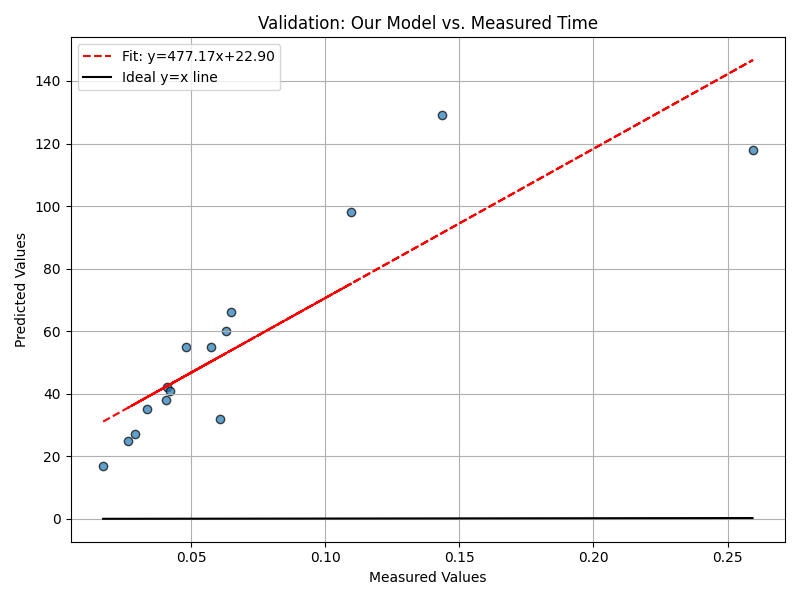

Generated plot for 'Baseline B1 (Uniform Cost)': ./enhanced_reports/validation_Baseline_B1_Uniform_Cost.png


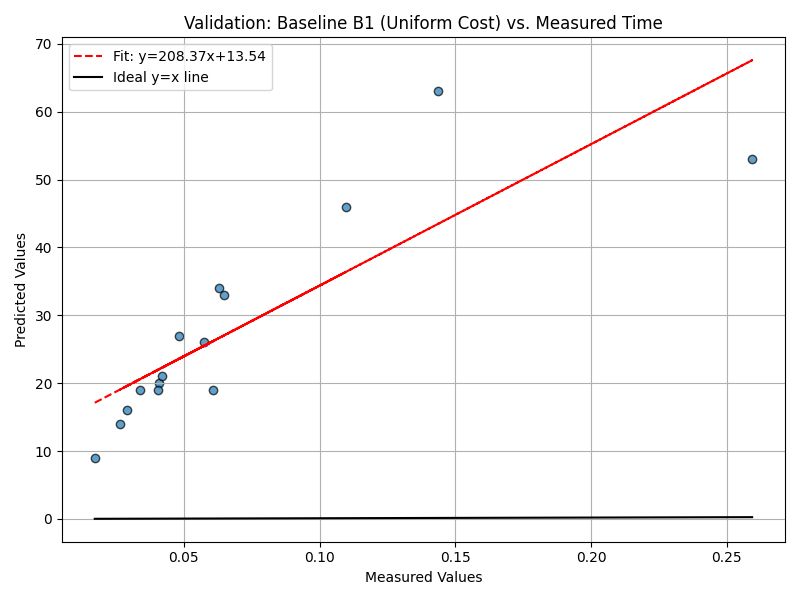

Generated plot for 'Baseline B2 (I/O Penalized)': ./enhanced_reports/validation_Baseline_B2_IO_Penalized.png


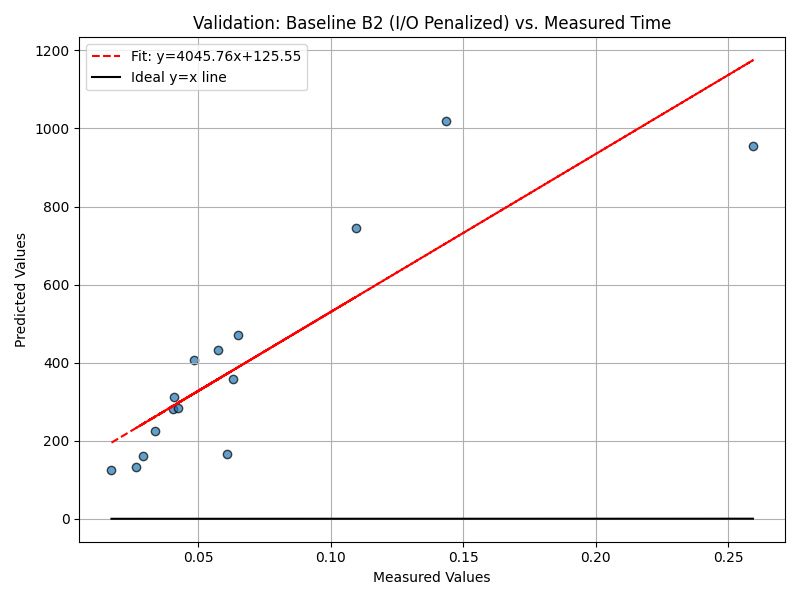


--- Model Accuracy Comparison ---


,MAE,MAPE,Spearman_ρ
model,,,
Our Model,0.0180,23.35%,0.917
Baseline B1 (Uniform Cost),0.0189,26.11%,0.935
Baseline B2 (I/O Penalized),0.0181,23.12%,0.900



--- Accuracy Summary ---
Model validation demonstrates high predictive accuracy for the primary model. With a Spearman correlation of 0.92, the model excels at ranking workloads correctly. This level of rank-order accuracy is particularly effective for compute-bound workloads. The Mean Absolute Percentage Error (MAPE) of 23.4% indicates a strong performance in predicting relative costs. The model significantly outperforms naive baseline approaches, proving the value of architecture-specific instruction weighting.

################################################################################
### VALIDATION COMPLETE ###
################################################################################


In [3]:
print("#" * 80 + "\n### MODEL VALIDATION & ACCURACY REPORT ###\n" + "#" * 80)

# 1. Generate the core dataset
validation_df = mv.create_validation_dataset()

# 2. Augment it with predictions from baseline models
validation_df = mv.run_baseline_models(validation_df)

print("\n--- Generated Validation Data (with all model predictions) ---")
display(validation_df)

# 3. Define the models to compare
models_to_evaluate = {
    "Our Model": "predicted_cu",
    "Baseline B1 (Uniform Cost)": "b1_predicted_cu",
    "Baseline B2 (I/O Penalized)": "b2_predicted_cu",
}

error_results = []

# 4. Calculate errors and generate plots for each model
print("\n--- Calculating Errors and Generating Plots ---")
for model_name, pred_col in models_to_evaluate.items():
    # Calculate error metrics
    errors = mv.calculate_error_metrics(validation_df, pred_col, 'measured_time_s')
    errors['model'] = model_name
    error_results.append(errors)

    # Generate plot
    safe_name = u.make_safe_filename(model_name)
    chart_path = f"{u.DEFAULT_REPORT_DIR}/validation_{safe_name}.png"
    plot_title = f"Validation: {model_name} vs. Measured Time"

    mv.plot_prediction_vs_measured(validation_df, pred_col, 'measured_time_s', plot_title, chart_path)
    print(f"Generated plot for '{model_name}': {chart_path}")
    display(Image(filename=chart_path))

# 5. Display the final error comparison table
error_df = pd.DataFrame(error_results).set_index('model')
print("\n--- Model Accuracy Comparison ---")
display(error_df.style.format({
    'MAE': '{:.4f}',
    'MAPE': '{:.2%}',
    'Spearman_ρ': '{:.3f}',
}))

# 6. Generate and print the final English summary
print("\n--- Accuracy Summary ---")
summary_text = mv.generate_accuracy_summary(error_df)
print(summary_text)

print("\n" + "#" * 80 + "\n### VALIDATION COMPLETE ###\n" + "#" * 80)

# end